# **1. Detecção da GPU Disponível**

Verifica se há uma GPU acessível no ambiente de execução, permitindo confirmar se o treinamento poderá utilizar aceleração por hardware.



In [1]:
!nvidia-smi

Wed Nov 26 11:02:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 80GB HBM3          On  |   00000000:1B:00.0 Off |                    0 |
| N/A   27C    P0             68W /  700W |       0MiB /  81559MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# **2. Preparação do Ambiente de Execução**

Identifica se o notebook está sendo executado no Google Colab ou localmente, ajustando caminhos, encoding e seleção de GPU para garantir compatibilidade do pipeline.


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!nvcc --version

try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False

print('Running on Google Colab = ', _ON_COLAB)
import os
import torch
from IPython import get_ipython
import os
# Definir o caminho base
if _ON_COLAB:
    BASE_PATH = "/content"
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
else:
    BASE_PATH = "/lapix/compartilhado/asbestos/resnet/resnet34/" # trocar para o base path do seu computador se estiver rodando localmente, deixar /lapix se estiver rodando nos conteiners lapix
    VISIBLE_GPUS = [0] # Selecionar a GPU PARA RODAR! VER QUAL ESTA LIVRE

    if torch.cuda.device_count() != 8:
        print("GPU SETADA - PULANDO ETAPA")
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        os.environ["NVIDIA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        print("CUDA GPUS NUMBER: ", torch.cuda.device_count())
    
os.chdir(BASE_PATH) # garantir que está executando no caminho base definido

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:18:24_PDT_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0
Running on Google Colab =  False
CUDA GPUS NUMBER:  1


# **3. Configuração de avisos**

Suprime mensagens de aviso das bibliotecas, mantendo a saída do notebook mais limpa durante a execução.


In [3]:
import warnings
warnings.filterwarnings('ignore')

# **4. Verificação da GPU pelo PyTorch**

Verifica se o PyTorch reconhece GPU ou backend MPS disponível e exibe informações sobre o dispositivo para diagnóstico do ambiente de execução.


In [ ]:
import torch
print("CUDA disponível? ", torch.cuda.is_available())
print("Qtd GPUs: ", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU: ", torch.cuda.get_device_name(0))
else:
    # Apple
    print("MPS disponível (Apple Silicon)? ", getattr(torch.backends, "mps", None) and torch.backends.mps.is_available())


# **5. Inicialização do Fastai para Visão Computacional**

Importa o módulo de visão computacional do Fastai e confirma se há suporte a GPU disponível para acelerar o treinamento dos modelos.


In [5]:
from fastai.vision.all import *
print("fastai detectou GPU?:", torch.cuda.is_available())


fastai detectou GPU?: True


In [ ]:
# **6. Inspeção inicial da imagem com scikit-image**

Carrega um exemplo de raio X do dataset usando scikit-image e exibe o formato e o tipo de dados da imagem, conferindo se o arquivo está acessível e adequado para processamento.


In [6]:
from skimage import io
import os

# Caminho para a imagem
#imgPath = '/content/labels/Asbestosis signs/158127965063113306992304369857531130990_6hpunp.jpg'
#imgPath = r'amostra_convertidas/pleural_effusion/101354916913099012081924155376991837012_81ss65.jpg'
# imgPath = r'/lapix/compartilhado/asbestos/resnet/resnet_img_filtradas/Padchest_NIH_reduzido/labels/Asbestosis signs/158127965063113306992304369857531130990_6hpunp.jpg'
imgPath = r'/lapix/compartilhado/asbestos/resnet/resnet_img_filtradas/Padchest_NIH/Padchest_NIH/dataset2_lungonly/train/Pneumonia/00003523_011.jpg'

# Verificar se o arquivo existe
if os.path.exists(imgPath):
    # Carregar a imagem com skimage
    img = io.imread(imgPath)

    tipo_dado = img.dtype  # Acessando o tipo de dado da imagem

    # Exibir as propriedades
    print(f"Shape: {img.shape}")
    print(f"Tipo de dado: {tipo_dado}")
else:
    print("O arquivo não foi encontrado. Verifique o caminho.")

Shape: (1024, 1024, 3)
Tipo de dado: uint8


# **7. Inspeção da imagem com OpenCV**

Carrega o mesmo raio X com OpenCV e exibe o formato e o tipo de dados, permitindo comparar a leitura da imagem entre diferentes bibliotecas.


In [7]:
import cv2
import os

# Caminho para a imagem
#imgPath = '/content/labels/Asbestosis signs/158127965063113306992304369857531130990_6hpunp.jpg'
#imgPath = r'amostra_convertidas/pleural_effusion/101354916913099012081924155376991837012_81ss65.jpg'
# imgPath = r'/lapix/compartilhado/asbestos/resnet/resnet_img_filtradas/Padchest_NIH_reduzido/labels/Asbestosis signs/158127965063113306992304369857531130990_6hpunp.jpg'
imgPath = r'/lapix/compartilhado/asbestos/resnet/resnet_img_filtradas/Padchest_NIH/Padchest_NIH/dataset2_lungonly/train/Pneumonia/00003523_011.jpg'


# Verificar se o arquivo existe
if os.path.exists(imgPath):
    # Carregar a imagem com OpenCV (por padrão, em BGR)
    img = cv2.imread(imgPath)

    if img is None:
        print("Erro ao carregar a imagem com OpenCV.")
    else:
        tipo_dado = img.dtype

        print(f"Shape: {img.shape}")
        print(f"Tipo de dado: {tipo_dado}")
else:
    print("O arquivo não foi encontrado. Verifique o caminho.")

Shape: (1024, 1024, 3)
Tipo de dado: uint8


# **8. Visualização da imagem com diferentes mapas de cor**

Aplica mapas de cor (JET, BONE e VIRIDIS) sobre o raio X em escala de cinza, comparando a imagem original com versões realçadas para destacar estruturas de interesse.


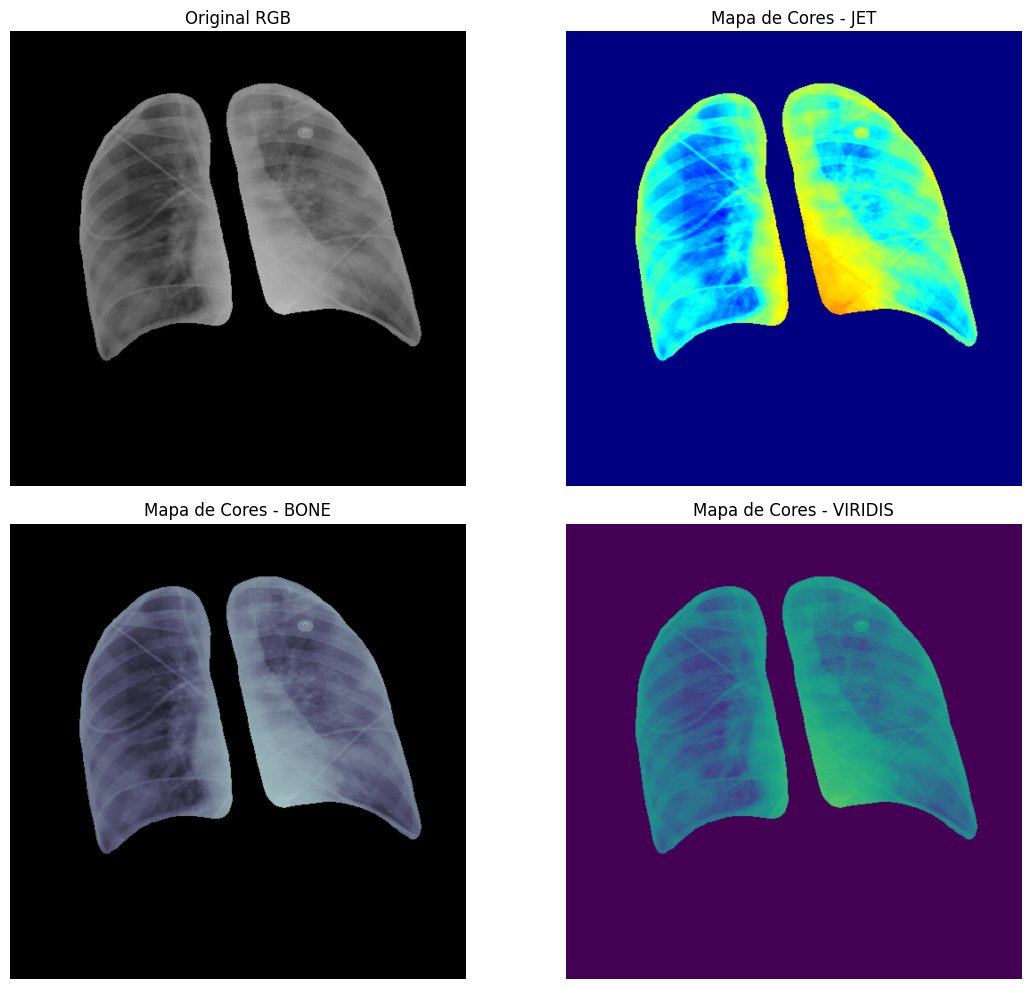

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Caminho da imagem
#imgPath = '/content/labels/Asbestosis signs/158127965063113306992304369857531130990_6hpunp.jpg'
#imgPath = r'amostra_convertidas/pleural_effusion/101354916913099012081924155376991837012_81ss65.jpg'
imgPath = r'/lapix/compartilhado/asbestos/resnet/resnet_img_filtradas/Padchest_NIH/Padchest_NIH/dataset2_lungonly/train/Pneumonia/00003523_011.jpg'


# Carrega imagem BGR e converte para RGB
orig_bgr = cv2.imread(imgPath, cv2.IMREAD_COLOR)
if orig_bgr is None:
    raise FileNotFoundError("Imagem não encontrada.")
orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)

# Converter para escala de cinza
gray = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2GRAY)

# Aplicar mapas de cor com OpenCV (JET e BONE)
color_jet = cv2.applyColorMap(gray, cv2.COLORMAP_JET)
color_bone = cv2.applyColorMap(gray, cv2.COLORMAP_BONE)
color_viridis = cv2.applyColorMap(gray, cv2.COLORMAP_VIRIDIS)

# Converter para RGB (BGR → RGB)
color_jet_rgb = cv2.cvtColor(color_jet, cv2.COLOR_BGR2RGB)
color_bone_rgb = cv2.cvtColor(color_bone, cv2.COLOR_BGR2RGB)
color_viridis_rgb = cv2.cvtColor(color_viridis, cv2.COLOR_BGR2RGB)

# Plotar
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
ax = axes.ravel()

ax[0].imshow(orig_rgb)
ax[0].set_title("Original RGB")
ax[0].axis('off')

ax[1].imshow(color_jet_rgb)
ax[1].set_title("Mapa de Cores - JET")
ax[1].axis('off')

ax[2].imshow(color_bone_rgb)
ax[2].set_title("Mapa de Cores - BONE")
ax[2].axis('off')

# Usar matplotlib para aplicar viridis
ax[3].imshow(color_viridis_rgb)
ax[3].set_title("Mapa de Cores - VIRIDIS")
ax[3].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# **9. Configuração de bibliotecas e reprodutibilidade**

Importa as bibliotecas usadas para augmentação de imagens, manipulação de dados e visão computacional, além de definir a semente aleatória para garantir reprodutibilidade nos experimentos.


In [9]:
import random
from pathlib import Path

import albumentations as A
import numpy as np
import pandas as pd
from fastai.vision.all import *
#from lapixdl.evaluation.evaluate import evaluate_classification
#from lapixdl.evaluation.model import Classification

# Fix seed
random.seed(81615)

# **9. Configuração de bibliotecas e reprodutibilidade**

Importa as bibliotecas usadas para augmentação de imagens, manipulação de dados e visão computacional, além de definir a semente aleatória para garantir reprodutibilidade nos experimentos.


In [10]:
class AlbumentationsTransform(Transform):
    split_idx = 0

    def __init__(self, aug):
        self.aug = aug

    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))["image"]
        return PILImage.create(aug_img)

# **11. Definição dos diretórios do experimento**

Configura o caminho raiz do dataset de radiografias, além das pastas de saída e do diretório onde os modelos treinados serão salvos.


In [11]:
path_dataset = Path(r"/lapix/compartilhado/asbestos/resnet/resnet_img_filtradas/Padchest_NIH/Padchest_NIH/dataset2_lungonly")
path_img = path_dataset
  # Images root folder. The images must be inside the [train|val|test]/[class] folders.
path_output = Path("output_lungonly")
path_models = (
    path_output /"models4"
)  # Folder where the models/weights should be saved in

path_models.mkdir(parents=True, exist_ok=True)


# **13. Função auxiliar para amostragem de imagens**

Define uma função auxiliar para selecionar aleatoriamente um subconjunto de imagens de uma pasta e movê-las para outro diretório, recurso útil apenas em etapas manuais de organização do dataset.


In [12]:
import shutil
import random
def random_sample_images(dirpath, destfolder, nimages):
  files_list = os.listdir(dirpath)
  for filename in random.sample(files_list, nimages):
    shutil.move(os.path.join(dirpath, filename), os.path.join(destfolder, filename))

# **14. Configuração dos caminhos do dataset e dos modelos**

Define o caminho principal do dataset de radiografias, a pasta de saída dos resultados e o diretório onde os modelos treinados serão armazenados, garantindo que toda a estrutura de arquivos usada nos experimentos esteja organizada.


In [13]:
from pathlib import Path
import os

path_dataset = Path("/lapix/compartilhado/asbestos/resnet/resnet_img_filtradas/Padchest_NIH/Padchest_NIH/dataset2_lungonly")
path_img = path_dataset

path_output = Path("output_lungonly")
path_models = path_output / "models"  

os.makedirs(path_models, exist_ok=True)

print("Dataset:", path_dataset)
print("Saída  :", path_output)
print("Modelos:", path_models)


Dataset: /lapix/compartilhado/asbestos/resnet/resnet_img_filtradas/Padchest_NIH/Padchest_NIH/dataset2_lungonly
Saída  : output_lungonly
Modelos: output_lungonly/models


In [14]:
PATH_DATASET = Path(path_dataset) if 'path_dataset' in globals() else Path("./dataset")
PATH_MODELS  = Path(path_models)  if 'path_models'  in globals() else Path("./models")


## Setup (imports, seed, paths, DataLoaders, registro de modelos)

# **16. Filtragem de classes utilizadas no experimento**

Aplica um filtro para considerar apenas um subconjunto das classes disponíveis no dataset durante o carregamento das imagens. Nenhum arquivo é modificado no disco; o filtro atua somente na criação dos DataLoaders, garantindo que apenas as classes selecionadas sejam usadas no treinamento, validação e teste.


In [15]:
# --- Imports e setup ---
import os, gc, json, time
from pathlib import Path
import numpy as np
import pandas as pd
import torch

from fastai.vision.all import *
from fastai.callback.schedule import valley, slide
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)

import albumentations as A
from torchvision.models import resnet34, resnet50, vgg16_bn, efficientnet_b0

# Reprodutibilidade
def set_seed(seed=42):
    import random
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic = True

set_seed(42)

# --- Paths (use suas variáveis já definidas, se existirem) ---
PATH_DATASET = Path(path_dataset) if 'path_dataset' in globals() else Path("./dataset")
PATH_MODELS  = Path(path_models)  if 'path_models'  in globals() else Path("./models")
PATH_MODELS.mkdir(parents=True, exist_ok=True)

# --- Device ---
DEV = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEV)

# ============================================================
#   DEFINA AQUI QUAIS CLASSES QUER TREINAR NESTE EXPERIMENTO
# ============================================================
# Os nomes devem ser exatamente os nomes das pastas dentro de
# PATH_DATASET/train, PATH_DATASET/val, PATH_DATASET/test
ALLOWED_LABELS = [
    "Normal",
#    "Asbestosis signs",
    "Pneumonia",
    "Atelectasis",
    "Fibrosis",
#    "Effusion",
    "Pleural_Thickening",
#    "Outras_Doencas"
]


print("Classes incluídas neste experimento:", ALLOWED_LABELS)

# --- Augmentations e DataLoaders ---
augmentations = A.Compose([
    A.HorizontalFlip(p=0.0),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.05, rotate_limit=7, p=0.7),
    A.RandomBrightnessContrast(0.08, 0.08, p=0.6),
    A.RandomGamma(gamma_limit=(90,110), p=0.4),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=0.2),
], p=1.0)

batch_tfms = [
    AlbumentationsTransform(augmentations),
    Normalize.from_stats(*imagenet_stats)
]

metrics = [accuracy, F1Score(average="macro"), Precision(average="macro"), Recall(average="macro")]

bs = 16

# ---------- FILTRO DE CLASSES (train/val) VIA DATABLOCK ----------
def get_items_filtered(path: Path):
    """
    Retorna apenas imagens das pastas 'train' e 'val'
    cujas labels (nome da pasta) estão em ALLOWED_LABELS.
    """
    all_files = get_image_files(path)
    return [
        f for f in all_files
        if f.parent.parent.name in ["train", "val"]   # garante só train/val
        and f.parent.name in ALLOWED_LABELS          # filtra classes
    ]

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_items_filtered,
    splitter=GrandparentSplitter(train_name="train", valid_name="val"),
    get_y=parent_label,
    item_tfms=Resize(1024),
    batch_tfms=batch_tfms,
)

# Mantém o mesmo nome 'data' que você usava antes
data = dblock.dataloaders(PATH_DATASET, bs=bs, device=DEV)

print("Vocab (classes que o modelo enxerga):", data.vocab)

# ---------- TEST SET FILTRADO NAS MESMAS CLASSES ----------
test_root = PATH_DATASET / "test"
test_files = [
    f for f in get_image_files(test_root)
    if f.parent.name in ALLOWED_LABELS
]

test_dl = data.test_dl(test_files, with_labels=True)

# --- Registro de modelos ---
MODEL_REGISTRY = {
    "resnet34": resnet34,
#    "resnet50": resnet50,
#    "vgg16_bn": vgg16_bn,
#    "efficientnet_b0": efficientnet_b0,
}
MONITOR_METRIC = "f1_score"
MASTER_CSV     = PATH_MODELS / "experimentos_grid_vision.csv"


Device: cuda
Classes incluídas neste experimento: ['Normal', 'Pneumonia', 'Atelectasis', 'Fibrosis', 'Pleural_Thickening']
Vocab (classes que o modelo enxerga): ['Atelectasis', 'Fibrosis', 'Normal', 'Pleural_Thickening', 'Pneumonia']



# **17. Funções auxiliares de treinamento e avaliação - Helpers (learner, lr_find seguro, treinar fase, avaliação no /test, util CSV)**

Define funções auxiliares para criar o learner do Fastai, buscar uma taxa de aprendizado adequada, treinar cada fase do modelo com salvamento automático dos melhores pesos, avaliar o desempenho no conjunto de teste e registrar os resultados em arquivo CSV.


In [16]:
def get_learner(dls, arch_fn, pretrained=True, unfreeze=False):
    learn = vision_learner(
        dls, arch_fn, pretrained=pretrained,
        metrics=metrics, loss_func=CrossEntropyLossFlat()
    )
    learn.to(DEV)
    if DEV.type == 'cuda': learn = learn.to_fp16()
    if unfreeze: learn.unfreeze()
    learn.path = PATH_MODELS
    return learn

def safe_lr_find(learn, num_it=None, start_lr=1e-7, end_lr=1e-1):
    if num_it is None: num_it = min(60, len(learn.dls.train))
    try:
        sugg = learn.lr_find(start_lr=start_lr, end_lr=end_lr, num_it=num_it, stop_div=False,
                             suggest_funcs=(valley, slide))
        lr = getattr(sugg, 'valley', None)
        return float(lr) if lr is not None else 1e-3
    except Exception as e:
        print("lr_find falhou:", repr(e)); return 1e-3

def train_phase(model_name, arch_fn, dls, phase, base_ckpt, epochs, wd=1e-3, lr=None):
    assert phase in ("transfer","finetune")
    unfreeze_flag = (phase == "finetune")
    learn = get_learner(dls, arch_fn, pretrained=True, unfreeze=unfreeze_flag)

    if base_ckpt:
        try:
            learn.load(base_ckpt); print(f"[{model_name}:{phase}] carregado: {base_ckpt}")
        except Exception as e:
            print(f"[{model_name}:{phase}] não carregou {base_ckpt}: {e}")

    if phase == "finetune" and DEV.type == 'cuda':
        learn.to_fp32(); learn.unfreeze()

    if lr is None: lr = safe_lr_find(learn)

    ckpt_name = f"{model_name}_{phase}"
    cbs = [SaveModelCallback(monitor=MONITOR_METRIC, fname=ckpt_name, with_opt=True)]
    print(f"[{model_name}:{phase}] epochs={epochs}, lr_max={lr}, wd={wd}")
    with learn.no_bar():
        learn.fit_one_cycle(epochs, lr_max=lr, wd=wd, cbs=cbs)

    # histórico por época
    hist = []
    names = learn.recorder.metric_names
    for row in learn.recorder.values:
        rec = dict(zip(names[1:-1], row))
        hist.append(rec)

    del learn; gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    return ckpt_name, hist

def evaluate_on_test(dls, ckpt_name, arch_fn, model_name, phase, allowed_labels=None):
    learn = get_learner(dls, arch_fn, pretrained=True, unfreeze=False)
    learn.load(ckpt_name)

    test_root = PATH_DATASET / "test"

    # === FILTRO DE CLASSES TAMBÉM NO TEST ===
    if allowed_labels is not None:
        test_files = [
            f for f in get_image_files(test_root)
            if f.parent.name in allowed_labels
        ]
    else:
        test_files = get_image_files(test_root)

    assert len(test_files) > 0, f"Nenhuma imagem em {test_root} depois do filtro."

    test_dl = dls.test_dl(test_files, with_labels=True)
    preds, targs = learn.get_preds(dl=test_dl)
    y_true = targs.cpu().numpy()
    y_pred = preds.argmax(dim=1).cpu().numpy()

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1   = f1_score(y_true, y_pred, average="macro")

    try:
        n_classes = preds.shape[1]
        y_true_ovr = np.eye(n_classes)[y_true]
        roc_auc_macro = roc_auc_score(
            y_true_ovr, preds.cpu().numpy(),
            average='macro', multi_class='ovr'
        )
    except Exception:
        roc_auc_macro = np.nan

    clf_rep = classification_report(
        y_true, y_pred,
        target_names=list(map(str, (getattr(dls, 'vocab', None) or getattr(dls.train, 'vocab', [])))),
        zero_division=0
    )

    del learn; gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()

    return {
        "model": model_name, "phase": phase, "ckpt": ckpt_name,
            "test_accuracy": acc, "test_precision_macro": prec,
            "test_recall_macro": rec, "test_f1_macro": f1,
            "test_roc_auc_macro": roc_auc_macro, "classification_report": clf_rep
    }


def append_results_csv(rows, csv_path: Path):
    df = pd.DataFrame(rows)
    if csv_path.exists():
        df_old = pd.read_csv(csv_path)
        df = pd.concat([df_old, df], ignore_index=True)
    df.to_csv(csv_path, index=False)
    print("Resultados adicionados em:", csv_path)


# **18. Estágio 1 – Transfer learning e ranking dos modelos**

Realiza o treinamento inicial dos modelos pré-treinados (transfer learning) usando o dataset de radiografias filtrado, avalia o desempenho em teste e registra as métricas em CSV. Em seguida, gera um ranking dos modelos com base no F1-macro, permitindo selecionar as arquiteturas mais promissoras para ajustes posteriores.



### TRANSFER — resnet34 ###


[resnet34:transfer] epochs=75, lr_max=0.001258925418369472, wd=0.001
[0, 1.894780158996582, 1.2408524751663208, 0.5585806965827942, 0.4276831009441766, 0.4150716149849722, 0.4762464373568031, '02:13']
Better model found at epoch 0 with f1_score value: 0.4276831009441766.
[1, 1.4877880811691284, 0.943512499332428, 0.6374495029449463, 0.46290496956461125, 0.4631681089739784, 0.47407824672650223, '02:14']
Better model found at epoch 1 with f1_score value: 0.46290496956461125.
[2, 1.2311476469039917, 0.8204740285873413, 0.675039529800415, 0.48297966234401485, 0.5128947592863555, 0.4734231021080129, '02:15']
Better model found at epoch 2 with f1_score value: 0.48297966234401485.
[3, 1.1468164920806885, 0.7747892141342163, 0.6933075785636902, 0.4973518513459192, 0.5535061025144504, 0.47226411655272926, '02:12']
Better model found at epoch 3 with f1_score value: 0.4973518513459192.
[4, 1.0413545370101929, 0.769540011882782, 0.7098190784454346, 0.49501994578521036, 0.5865833907478584, 0.452588

Resultados adicionados em: output_lungonly/models/experimentos_grid_vision.csv


model     phase  test_accuracy  test_precision_macro  test_recall_macro  \
0  resnet34  transfer        0.95791              0.948458           0.935413   

   test_f1_macro  test_roc_auc_macro               ckpt  
0       0.941433            0.992162  resnet34_transfer

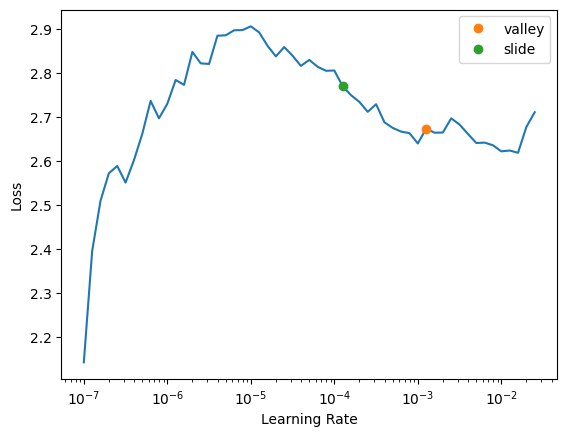

In [17]:
EPOCHS_TRANSFER = 75
WD_TRANSFER     = 1e-3
FIXED_LR_TRANSFER = None   # ex.: 1e-3 se quiser fixar

rows_stage1 = []

for model_name, arch_fn in MODEL_REGISTRY.items():
    print("\n" + "="*80)
    print(f"### TRANSFER — {model_name} ###")
    print("="*80)

    ckpt_transfer, hist = train_phase(
        model_name=model_name, arch_fn=arch_fn, dls=data,
        phase="transfer", base_ckpt=None,
        epochs=EPOCHS_TRANSFER, wd=WD_TRANSFER, lr=FIXED_LR_TRANSFER
    )

    # salvar histórico por época
    for epoch_idx, rec in enumerate(hist):
        rows_stage1.append({"model": model_name, "phase": "transfer", "epoch": epoch_idx, **rec})

    # avaliação no /test
    # avaliação no /test
    test_row = evaluate_on_test(
    data,
    ckpt_transfer,
    arch_fn,
    model_name,
    "transfer",
    allowed_labels=ALLOWED_LABELS,   # <<< passa a mesma lista usada no treino
    )
    rows_stage1.append({"model": model_name, "phase": "transfer", "epoch": "best_on_test", **{k:v for k,v in test_row.items() if k not in ("model","phase")}})

append_results_csv(rows_stage1, MASTER_CSV)

# Ranking por F1 (teste)
df_master = pd.read_csv(MASTER_CSV)
rank_transfer = (
    df_master[(df_master['phase']=="transfer") & (df_master['epoch'].astype(str)=="best_on_test")]
    .sort_values("test_f1_macro", ascending=False)
    [["model","phase","test_accuracy","test_precision_macro","test_recall_macro","test_f1_macro","test_roc_auc_macro","ckpt"]]
    .reset_index(drop=True)
)
rank_transfer


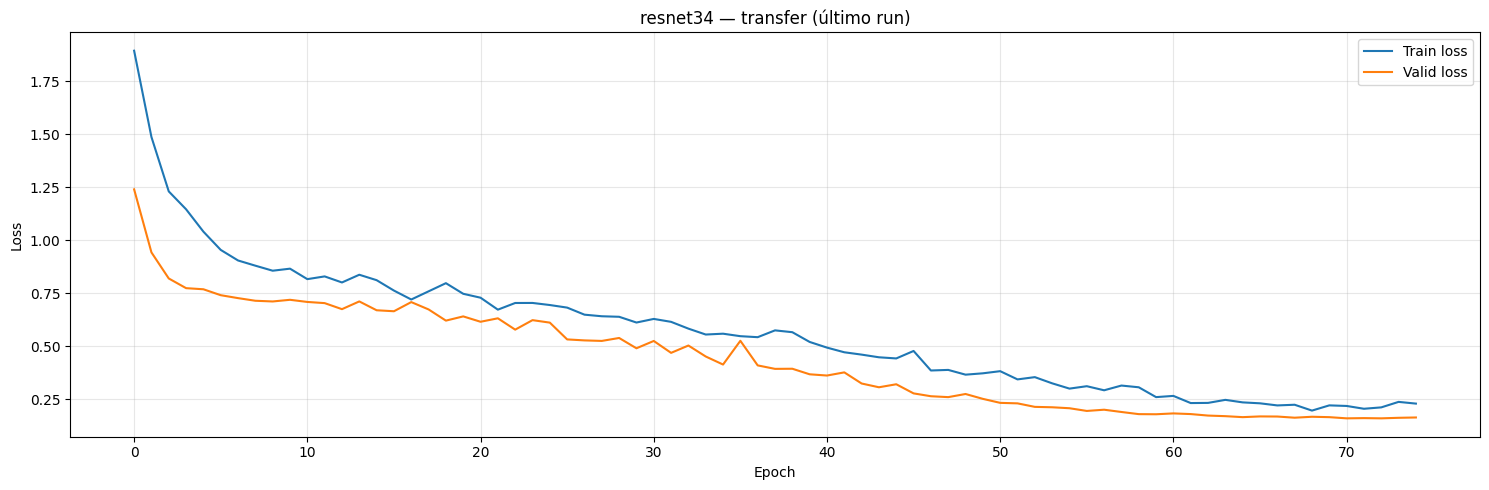

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Caminho do CSV com os históricos
CSV_PATH = Path("/lapix/compartilhado/asbestos/resnet/resnet34/output_lungonly/models/experimentos_grid_vision.csv")

# Nome do modelo que você quer plotar
MODEL_NAME = "resnet34"


def get_last_run_for_phase(df: pd.DataFrame, model_name: str, phase: str) -> pd.DataFrame:
    """
    Filtra o DataFrame para um dado modelo + phase e retorna
    APENAS o último run (caso existam múltiplos runs em que o epoch volta a 0).
    """
    # Filtra por modelo e phase
    df_phase = df[(df["model"] == model_name) & (df["phase"] == phase)].copy()

    # Remove linhas tipo "best_on_test" (epoch vazio)
    df_phase = df_phase[pd.to_numeric(df_phase["epoch"], errors="coerce").notna()].copy()
    df_phase["epoch"] = df_phase["epoch"].astype(int)

    # Ordena na ordem em que foi salvo (assumindo que o CSV está cronológico)
    df_phase = df_phase.sort_index()

    # Detecta "runs" pela volta do epoch (ex.: ... 58, 59, 60, 0, 1, 2, ...)
    run_ids = []
    current_run = 0
    prev_epoch = -1

    for ep in df_phase["epoch"]:
        if ep < prev_epoch:
            current_run += 1  # começou um novo run
        run_ids.append(current_run)
        prev_epoch = ep

    df_phase["run_id"] = run_ids

    # Pega APENAS o último run
    last_run_id = df_phase["run_id"].max()
    df_last = df_phase[df_phase["run_id"] == last_run_id].copy()

    return df_last


def plot_loss_curves(df: pd.DataFrame, model_name: str, phase: str):
    """
    Plota curvas de train_loss e valid_loss ao longo dos epochs
    para um modelo e phase específicos (transfer ou finetune).
    Sempre usa o último run encontrado.
    """
    df_last = get_last_run_for_phase(df, model_name, phase)

    if df_last.empty:
        print(f"Nenhum dado encontrado para model='{model_name}', phase='{phase}'.")
        return

    # Ordena por epoch só pra garantir
    df_last = df_last.sort_values("epoch")

    epochs = df_last["epoch"].values
    train_loss = df_last["train_loss"].values
    valid_loss = df_last["valid_loss"].values

    plt.figure(figsize=(15, 5))
    plt.plot(epochs, train_loss, label="Train loss")
    plt.plot(epochs, valid_loss, label="Valid loss")

    plt.title(f"{model_name} — {phase} (último run)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ============================
# Uso
# ============================

# Lê o CSV uma vez
df_hist = pd.read_csv(CSV_PATH)

# 1) Gráfico para TRANSFER LEARNING
plot_loss_curves(df_hist, MODEL_NAME, phase="transfer")


# **19. Estágio 2 – Fine-tuning dos modelos mais promissores**

Seleciona os modelos com melhor desempenho no estágio de transfer learning (Top-K) e realiza fine-tuning adicional a partir dos melhores checkpoints. Em seguida, reavalia o desempenho em teste e atualiza o ranking final dos modelos com base no F1-macro.


Selecionados para fine-tuning:


model     phase  test_accuracy  test_precision_macro  test_recall_macro  \
0  resnet34  transfer        0.95791              0.948458           0.935413   

   test_f1_macro  test_roc_auc_macro               ckpt  
0       0.941433            0.992162  resnet34_transfer


----------------------------------------------------------------------
### FINE-TUNING — resnet34 (a partir de resnet34_transfer) ###
----------------------------------------------------------------------
[resnet34:finetune] carregado: resnet34_transfer


[resnet34:finetune] epochs=25, lr_max=9.999999747378752e-06, wd=0.001
[0, 0.24095718562602997, 0.16180376708507538, 0.9634639024734497, 0.9497471745473518, 0.9551431047753132, 0.9450095248208328, '03:53']
Better model found at epoch 0 with f1_score value: 0.9497471745473518.
[1, 0.22721196711063385, 0.1678360551595688, 0.9606534242630005, 0.9470644564546458, 0.9535791798551123, 0.941312723631602, '03:53']
[2, 0.27515745162963867, 0.17101998627185822, 0.9587212204933167, 0.9430977352504429, 0.9537011232492114, 0.9332629333918039, '04:32']
[3, 0.3162498474121094, 0.1836729794740677, 0.9553837776184082, 0.9377506286062948, 0.938660814171031, 0.9373944870649382, '04:34']
[4, 0.32351934909820557, 0.2185179889202118, 0.9408044815063477, 0.9161202481190625, 0.9437477152531966, 0.89260133142873, '04:36']
[5, 0.32727205753326416, 0.19767418503761292, 0.9490602612495422, 0.9292060965526119, 0.9327288566089222, 0.9267335412036392, '04:29']
[6, 0.3235570788383484, 0.17607372999191284, 0.9539785981

Resultados adicionados em: output_lungonly/models/experimentos_grid_vision.csv


model     phase  test_accuracy  test_precision_macro  test_recall_macro  \
0  resnet34  finetune       0.967489              0.956989           0.944364   
1  resnet34  transfer       0.957910              0.948458           0.935413   

   test_f1_macro  test_roc_auc_macro               ckpt  
0       0.950462            0.995089  resnet34_finetune  
1       0.941433            0.992162  resnet34_transfer

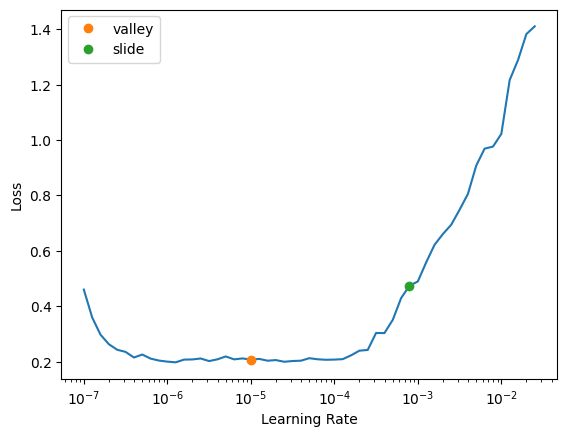

In [18]:
TOP_K = 1

EPOCHS_FINETUNE = 25
WD_FINETUNE     = 1e-3
FIXED_LR_FINETUNE = None     # ex.: slice(1e-5, 1e-4) para LR diferencial

rows_stage2 = []

topK = rank_transfer.head(TOP_K)
print("Selecionados para fine-tuning:")
display(topK)

for i, row in topK.iterrows():
    model_name = row["model"]
    arch_fn    = MODEL_REGISTRY[model_name]
    base_ckpt  = row["ckpt"]    # melhor do transfer

    print("\n" + "-"*70)
    print(f"### FINE-TUNING — {model_name} (a partir de {base_ckpt}) ###")
    print("-"*70)

    ckpt_finetune, hist = train_phase(
        model_name=model_name, arch_fn=arch_fn, dls=data,
        phase="finetune", base_ckpt=base_ckpt,
        epochs=EPOCHS_FINETUNE, wd=WD_FINETUNE, lr=FIXED_LR_FINETUNE
    )

    # histórico por época
    for epoch_idx, rec in enumerate(hist):
        rows_stage2.append({"model": model_name, "phase": "finetune", "epoch": epoch_idx, **rec})

    # avaliação no /test
    test_row = evaluate_on_test(data, ckpt_finetune, arch_fn, model_name, "finetune", allowed_labels=ALLOWED_LABELS)
    rows_stage2.append({"model": model_name, "phase": "finetune", "epoch": "best_on_test", **{k:v for k,v in test_row.items() if k not in ("model","phase")}})

append_results_csv(rows_stage2, MASTER_CSV)

# Ranking final (considera apenas linhas best_on_test)
df_master = pd.read_csv(MASTER_CSV)
final_rank = (
    df_master[df_master['epoch'].astype(str)=="best_on_test"]
    .sort_values("test_f1_macro", ascending=False)
    [["model","phase","test_accuracy","test_precision_macro","test_recall_macro","test_f1_macro","test_roc_auc_macro","ckpt"]]
    .reset_index(drop=True)
)
final_rank


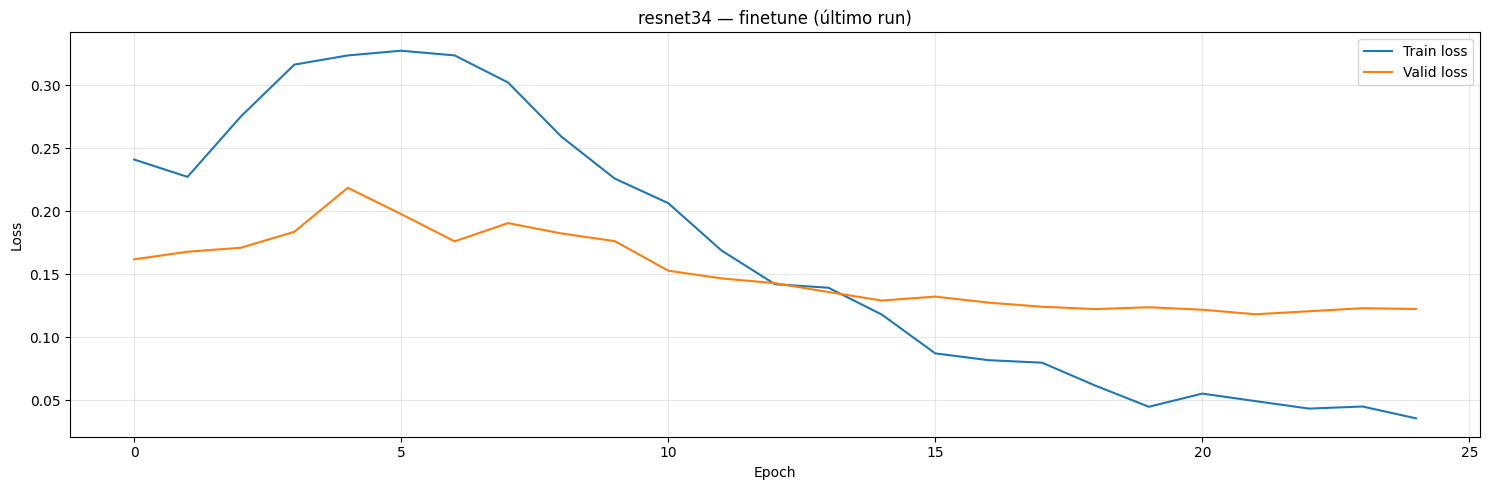

In [4]:
# 2) Gráfico para FINETUNE
plot_loss_curves(df_hist, MODEL_NAME, phase="finetune")

# **20. Matriz de confusão e exemplos do modelo campeão**

Seleciona o modelo com melhor desempenho no ranking final, calcula a matriz de confusão no conjunto de teste filtrado e exibe exemplos de previsões, permitindo uma análise qualitativa dos acertos e erros da CNN.


Melhor modelo: resnet34 | Fase: finetune | Checkpoint: resnet34_finetune
Classes presentes no /test depois do filtro: ['Atelectasis', 'Fibrosis', 'Normal', 'Pleural_Thickening', 'Pneumonia']
Vocab dos dls: ['Atelectasis', 'Fibrosis', 'Normal', 'Pleural_Thickening', 'Pneumonia']


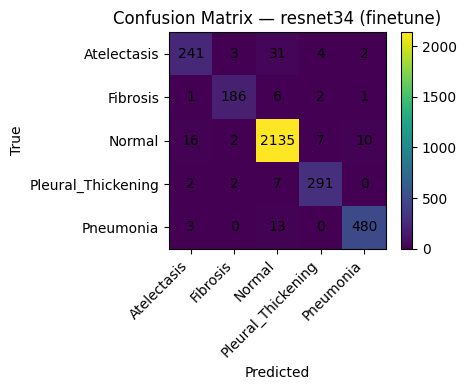

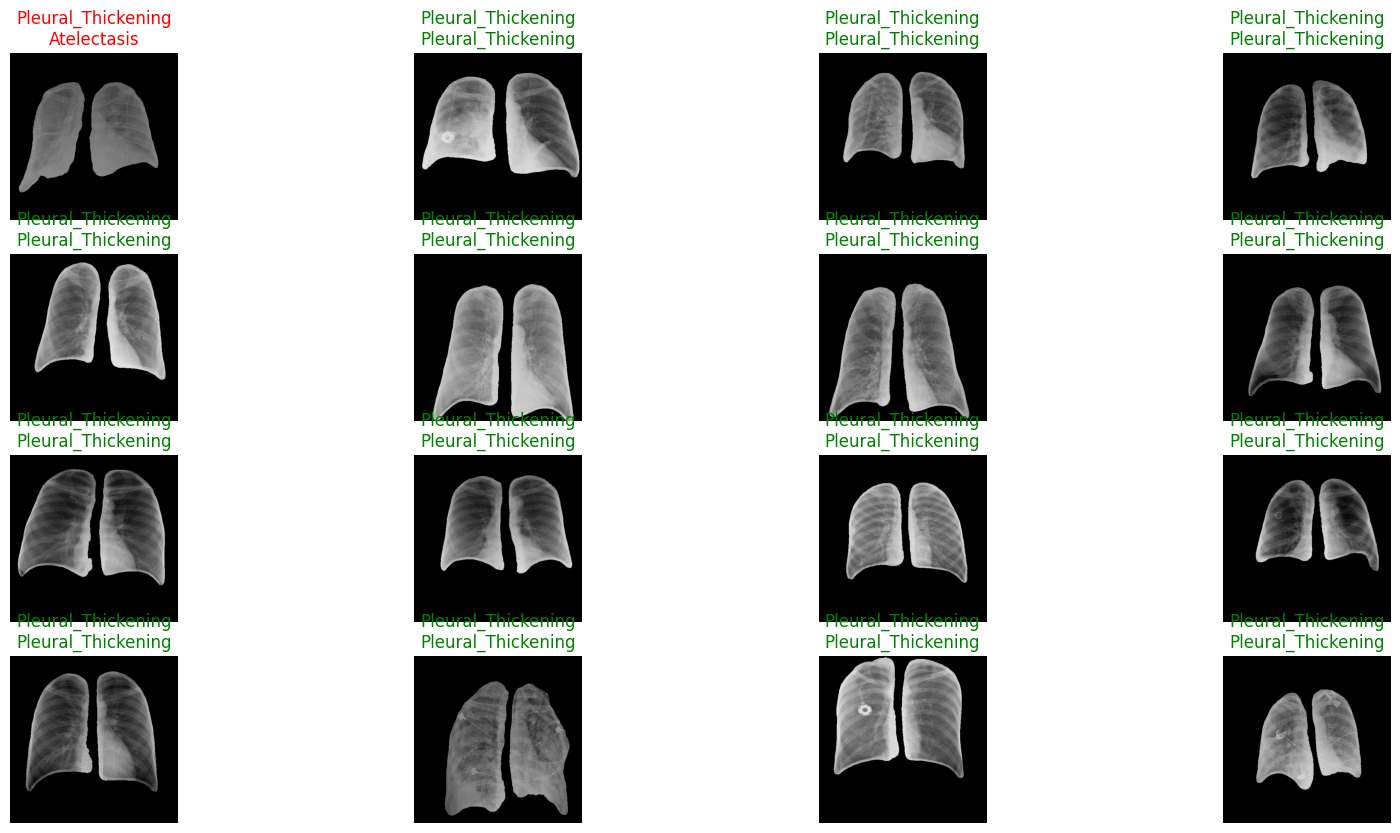

In [19]:
# ============================================================
#   MATRIZ DE CONFUSÃO E EXEMPLOS NO /test (FILTRADO)
# ============================================================

# Seleciona o melhor modelo a partir do ranking
BEST_MODEL = final_rank.iloc[0]["model"]
BEST_PHASE = final_rank.iloc[0]["phase"]
BEST_CKPT  = final_rank.iloc[0]["ckpt"]
BEST_ARCH  = MODEL_REGISTRY[BEST_MODEL]

print(f"Melhor modelo: {BEST_MODEL} | Fase: {BEST_PHASE} | Checkpoint: {BEST_CKPT}")

# Reconstrói o learner com os mesmos dls
learn = get_learner(data, BEST_ARCH, pretrained=True, unfreeze=False)
learn.load(BEST_CKPT)

# --------- Test set FILTRADO pelas mesmas classes ---------
test_root = PATH_DATASET / "test"

test_files = [
    f for f in get_image_files(test_root)
    if f.parent.name in ALLOWED_LABELS   # usa a lista já definida antes
]

# Sanidade: quais classes realmente aparecem no test depois do filtro?
test_labels_presentes = sorted({f.parent.name for f in test_files})
print("Classes presentes no /test depois do filtro:", test_labels_presentes)
print("Vocab dos dls:", list(map(str, (getattr(data, 'vocab', None) or getattr(data.train, 'vocab', [])))))

assert len(test_files) > 0, "Nenhuma imagem encontrada no /test após aplicar o filtro de classes!"

# Cria DataLoader de teste filtrado
test_dl = data.test_dl(test_files, with_labels=True)

# Predições
preds, targs = learn.get_preds(dl=test_dl)
y_true = targs.cpu().numpy()
y_pred = preds.argmax(dim=1).cpu().numpy()

# --------- Matriz de confusão ---------
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title(f"Confusion Matrix — {BEST_MODEL} ({BEST_PHASE})")

vocab = list(map(str, (getattr(data, 'vocab', None) or getattr(data.train, 'vocab', []))))
ax.set_xticks(range(len(vocab))); ax.set_xticklabels(vocab, rotation=45, ha='right')
ax.set_yticks(range(len(vocab))); ax.set_yticklabels(vocab)

for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center')

plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# --------- Exemplos do /test filtrado ---------
learn.show_results(dl=test_dl, max_n=16, figsize=(20,10))


# **21. Avaliação consolidada dos modelos e fases**

Percorre o ranking de modelos e fases (transfer e fine-tune), recalcula as métricas no conjunto de teste filtrado e exibe relatório de classificação, matriz de confusão e exemplos visuais para cada combinação, permitindo comparar o desempenho global das arquiteturas.



🔹 Avaliando modelo: RESNET34 | Fase: finetune | Checkpoint: resnet34_finetune


Accuracy: 0.9675 | Precision: 0.9570 | Recall: 0.9444 | F1: 0.9505

📊 Classification Report:
                    precision    recall  f1-score   support

       Atelectasis       0.92      0.86      0.89       281
          Fibrosis       0.96      0.95      0.96       196
            Normal       0.97      0.98      0.98      2170
Pleural_Thickening       0.96      0.96      0.96       302
         Pneumonia       0.97      0.97      0.97       496

          accuracy                           0.97      3445
         macro avg       0.96      0.94      0.95      3445
      weighted avg       0.97      0.97      0.97      3445



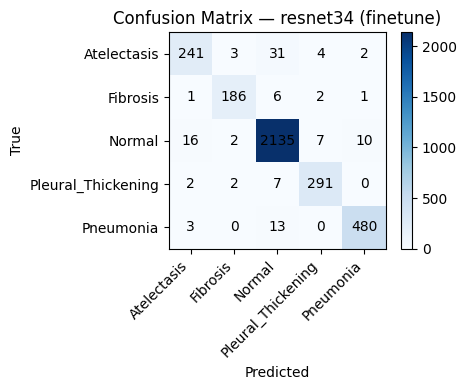

🖼️ Exemplos de predição (test filtrado):


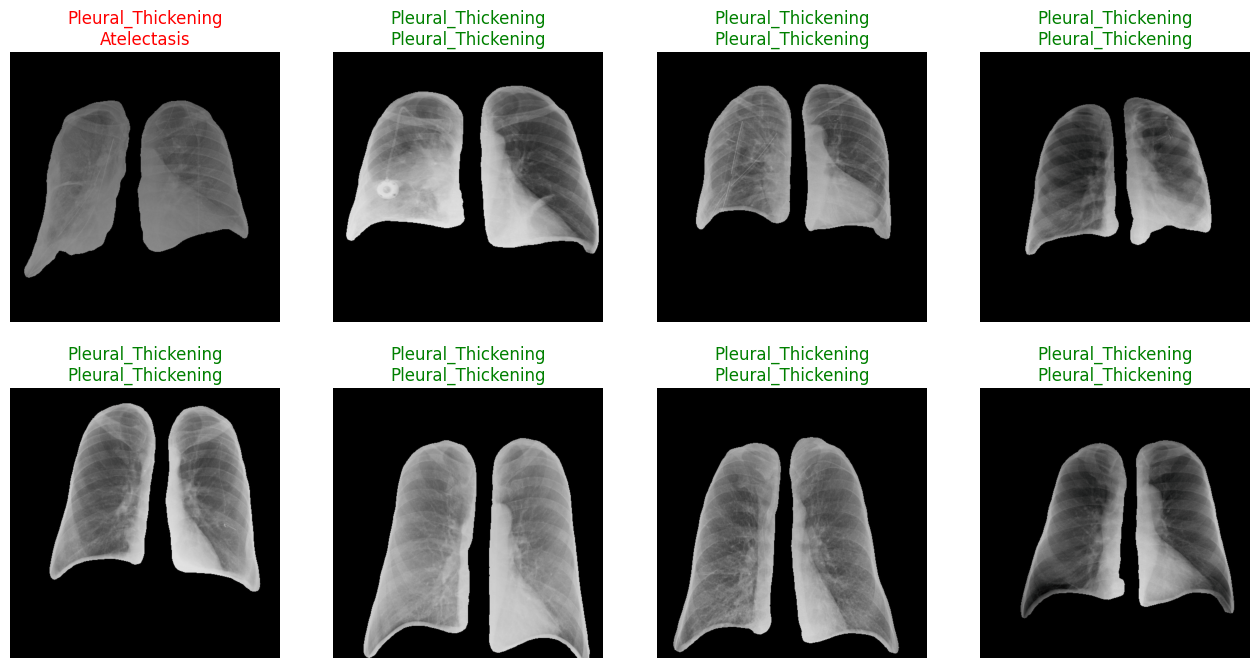


🔹 Avaliando modelo: RESNET34 | Fase: transfer | Checkpoint: resnet34_transfer


Accuracy: 0.9579 | Precision: 0.9485 | Recall: 0.9354 | F1: 0.9414

📊 Classification Report:
                    precision    recall  f1-score   support

       Atelectasis       0.93      0.84      0.88       281
          Fibrosis       0.95      0.96      0.95       196
            Normal       0.96      0.98      0.97      2170
Pleural_Thickening       0.94      0.96      0.95       302
         Pneumonia       0.96      0.93      0.95       496

          accuracy                           0.96      3445
         macro avg       0.95      0.94      0.94      3445
      weighted avg       0.96      0.96      0.96      3445



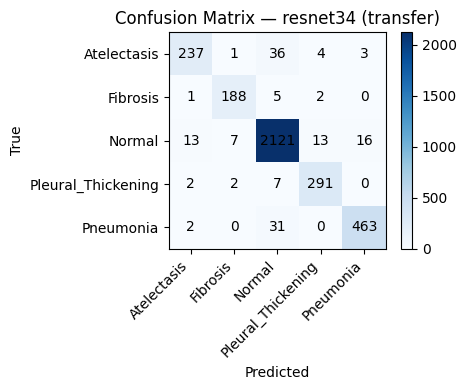

🖼️ Exemplos de predição (test filtrado):


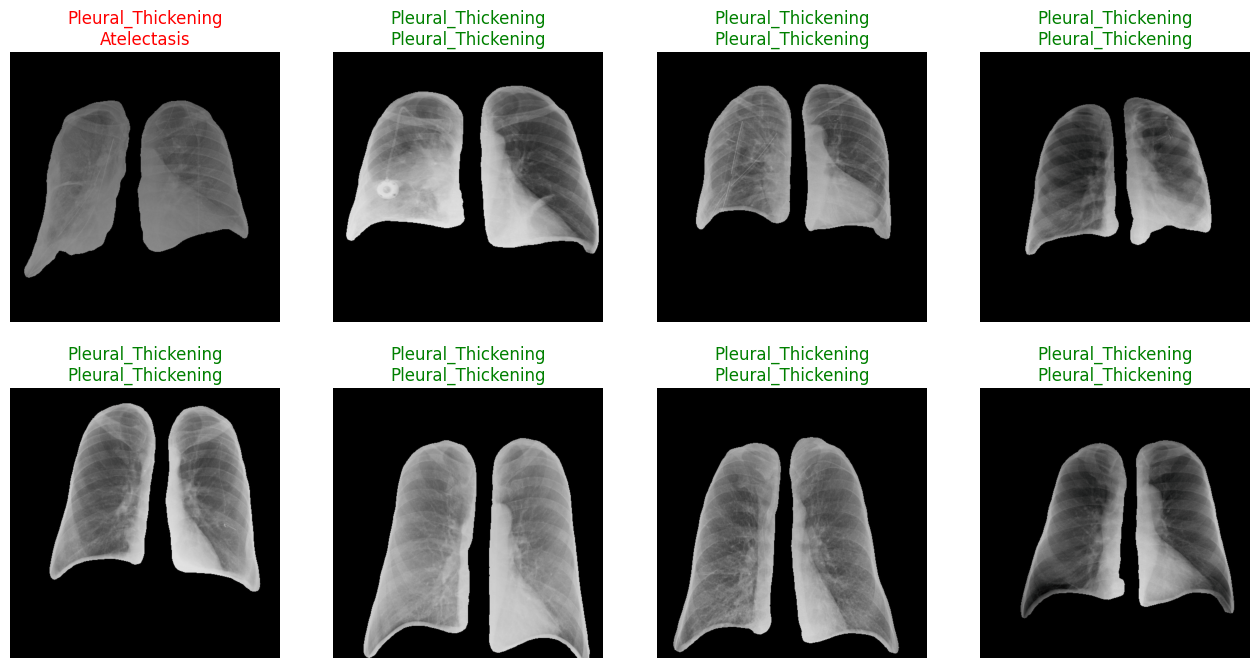

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Escolha o ranking de referência
# models_to_check = rank_transfer        # apenas transfer learning
models_to_check = final_rank.copy()      # transfer + fine-tune

# ============================================================
#   LOOP DE AVALIAÇÃO COM TESTE FILTRADO
# ============================================================

for i, row in models_to_check.iterrows():
    model_name = row["model"]
    phase      = row["phase"]
    ckpt_name  = row["ckpt"]
    arch_fn    = MODEL_REGISTRY[model_name]

    print("\n" + "="*100)
    print(f"🔹 Avaliando modelo: {model_name.upper()} | Fase: {phase} | Checkpoint: {ckpt_name}")
    print("="*100)

    # Carrega o modelo
    learn = get_learner(data, arch_fn, pretrained=True, unfreeze=False)
    learn.load(ckpt_name)

    # ========================================================
    #  TEST SET FILTRADO — usa as MESMAS classes do treino
    # ========================================================
    test_root = PATH_DATASET / "test"

    test_files = [
        f for f in get_image_files(test_root)
        if f.parent.name in ALLOWED_LABELS   # <<<<<<<<<< FILTRO IMPORTANTE
    ]

    assert len(test_files) > 0, "Nenhuma imagem no /test após aplicar o filtro!"

    test_dl = data.test_dl(test_files, with_labels=True)

    # Predições
    preds, targs = learn.get_preds(dl=test_dl)
    y_true = targs.cpu().numpy()
    y_pred = preds.argmax(dim=1).cpu().numpy()

    vocab = list(map(str, (getattr(data, 'vocab', None) or getattr(data.train, 'vocab', []))))

    # --- Métricas ---
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1   = f1_score(y_true, y_pred, average="macro")

    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}\n")

    # --- Classification Report ---
    print("📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=vocab, zero_division=0))

    # --- Matriz de Confusão ---
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.set_title(f"Confusion Matrix — {model_name} ({phase})")

    ax.set_xticks(range(len(vocab))); ax.set_xticklabels(vocab, rotation=45, ha="right")
    ax.set_yticks(range(len(vocab))); ax.set_yticklabels(vocab)

    for (r, c), v in np.ndenumerate(cm):
        ax.text(c, r, str(v), ha="center", va="center", color="black")

    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

    # --- Exemplos visuais ---
    print("🖼️ Exemplos de predição (test filtrado):")
    learn.show_results(dl=test_dl, max_n=8, figsize=(16, 8))
    plt.show()

    # Limpa GPU/memória entre modelos
    del learn
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


# **22. Probabilidades e visualização das predições do melhor modelo**

Utiliza o modelo campeão para obter as probabilidades de predição em um batch do conjunto de teste filtrado, gera uma tabela com rótulo verdadeiro, rótulo previsto e confiança, além de mostrar as imagens correspondentes. Também permite inspecionar o Top-5 de classes mais prováveis para uma amostra específica.


Usando modelo: resnet50 | fase: finetune | ckpt: resnet50_finetune


/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, *

idx_batch          true_label          pred_label  pred_conf(%)
0           0  Pleural_Thickening           Pneumonia         98.08
1           1  Pleural_Thickening            Effusion         75.56
2           2  Pleural_Thickening            Fibrosis         78.21
3           3  Pleural_Thickening         Atelectasis         89.58
4           4  Pleural_Thickening            Fibrosis         53.27
5           5  Pleural_Thickening            Effusion         90.84
6           6  Pleural_Thickening           Pneumonia         36.62
7           7  Pleural_Thickening  Pleural_Thickening         33.66
8           8  Pleural_Thickening    Asbestosis signs         54.53
9           9  Pleural_Thickening           Pneumonia         73.21
10         10  Pleural_Thickening              Normal         98.98
11         11  Pleural_Thickening  Pleural_Thickening         66.16

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.151983].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.1410894].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.977691].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2216997].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702837].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7685407].

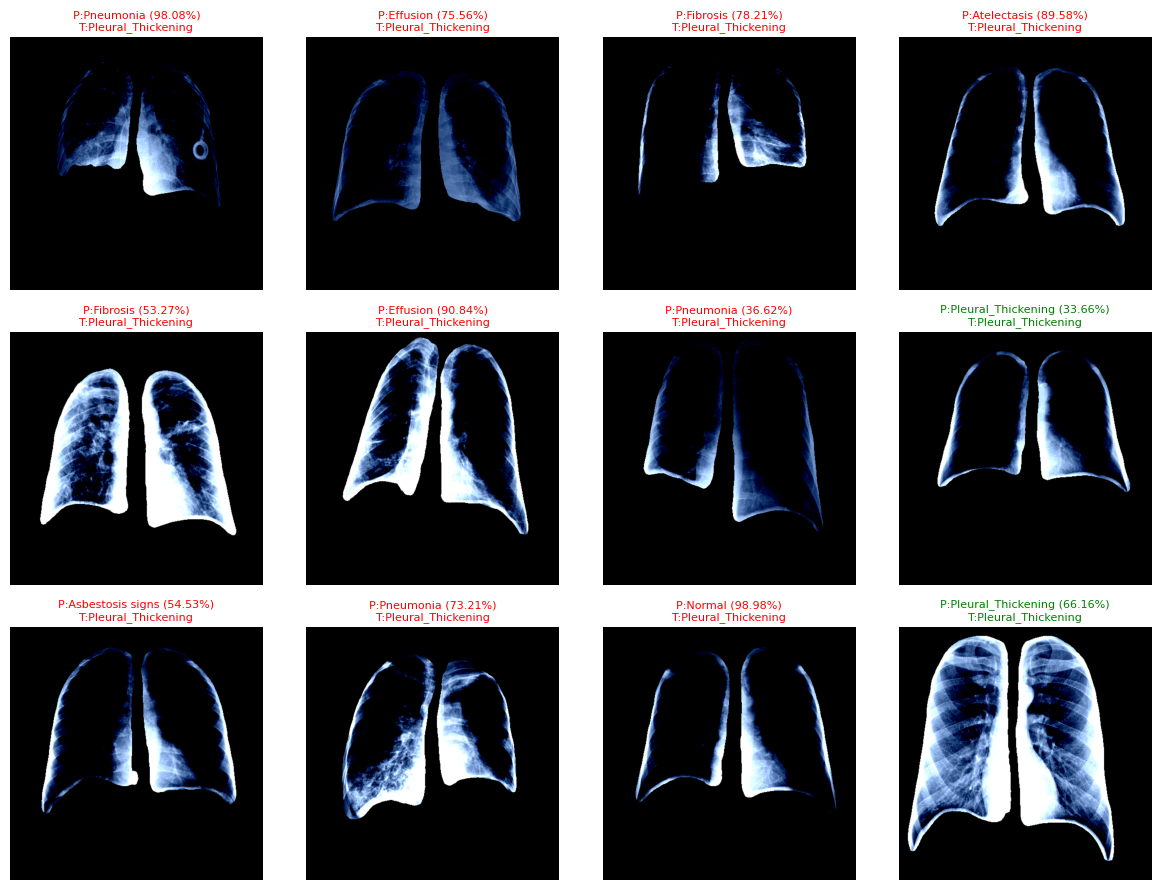


Top-5 para imagem 0:
  1. Pneumonia: 98.08%
  2. Effusion: 1.28%
  3. Asbestosis signs: 0.43%
  4. Outras_Doencas: 0.10%
  5. Atelectasis: 0.07%


In [30]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1) pegar melhor modelo
# =========================
BEST_MODEL = final_rank.iloc[0]["model"]
BEST_PHASE = final_rank.iloc[0]["phase"]
BEST_CKPT  = final_rank.iloc[0]["ckpt"]
BEST_ARCH  = MODEL_REGISTRY[BEST_MODEL]

print(f"Usando modelo: {BEST_MODEL} | fase: {BEST_PHASE} | ckpt: {BEST_CKPT}")

# =========================
# 2) carregar learner
# =========================
learn = get_learner(data, BEST_ARCH, pretrained=True, unfreeze=False)
learn.load(BEST_CKPT)

# =========================
# 3) montar DataLoader de teste
# =========================
test_root = PATH_DATASET / "test"
test_files = get_image_files(test_root)
test_dl = data.test_dl(test_files, with_labels=True)

# =========================
# 4) pegar UM batch e prever
# =========================
xb, yb = first(test_dl)   # xb: imagens, yb: labels
preds = learn.model(xb.to(learn.dls.device))
probs = preds.softmax(dim=1)

vocab = list(map(str, (getattr(data, 'vocab', None) or getattr(data.train, 'vocab', []))))

# quantas amostras mostrar
n_show = min(12, xb.shape[0])

rows = []
for i in range(n_show):
    true_idx = int(yb[i])
    pred_idx = int(probs[i].argmax().cpu())
    pred_conf = float(probs[i][pred_idx].cpu())
    rows.append({
        "idx_batch": i,
        "true_label": vocab[true_idx],
        "pred_label": vocab[pred_idx],
        "pred_conf(%)": round(pred_conf*100, 2)
    })

df_preds = pd.DataFrame(rows)
display(df_preds)

# =========================
# 5) visualizar imagens
# =========================
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.flatten()

for i in range(n_show):
    img = xb[i].cpu()
    # (C,H,W) -> (H,W,C)
    img_show = img.permute(1, 2, 0)
    axes[i].imshow(img_show)
    true_lbl = df_preds.loc[i, "true_label"]
    pred_lbl = df_preds.loc[i, "pred_label"]
    conf     = df_preds.loc[i, "pred_conf(%)"]
    color = "green" if true_lbl == pred_lbl else "red"
    axes[i].set_title(f"P:{pred_lbl} ({conf}%)\nT:{true_lbl}", color=color, fontsize=8)
    axes[i].axis("off")

# se tiver menos de 12 imagens no batch, apaga os eixos extras
for j in range(n_show, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

# =========================
# 6) função opcional: top-5 de uma imagem do batch
# =========================
def show_top5_for_sample(i, probs_tensor, vocab_list):
    probs_i = probs_tensor[i].cpu()
    top_conf, top_idx = probs_i.topk(5)
    print(f"\nTop-5 para imagem {i}:")
    for r, (c, idx_) in enumerate(zip(top_conf, top_idx)):
        print(f"  {r+1}. {vocab_list[int(idx_)]}: {float(c)*100:.2f}%")

# exemplo: mostrar o top-5 da primeira imagem
show_top5_for_sample(0, probs, vocab)

# limpa GPU se quiser
if torch.cuda.is_available():
    torch.cuda.empty_cache()


# **23. Análise das probabilidades de predição (Top-K)**

Calcula as probabilidades de predição do modelo campeão para cada imagem de um batch do conjunto de teste, exibe o Top-K de classes mais prováveis por amostra e mostra as imagens com seus rótulos verdadeiros e previstos, facilitando a interpretação do comportamento da rede.


Usando modelo: resnet50 | fase: finetune | ckpt: resnet50_finetune


/root/anaconda3/envs/lapixdl/lib/python3.11/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, *

idx_batch          true_label          pred_label  pred_conf(%)
0          0  Pleural_Thickening            Effusion         51.95
1          1  Pleural_Thickening              Normal         32.27
2          2  Pleural_Thickening           Pneumonia         78.83
3          3  Pleural_Thickening         Atelectasis         67.22
4          4  Pleural_Thickening              Normal         47.84
5          5  Pleural_Thickening         Atelectasis         76.35
6          6  Pleural_Thickening  Pleural_Thickening         49.34
7          7  Pleural_Thickening         Atelectasis         74.77

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.151983].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.1410894].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.977691].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2216997].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702837].



Imagem 0 — true: Pleural_Thickening
  1. Effusion -> 51.95%
  2. Atelectasis -> 15.87%
  3. Pleural_Thickening -> 14.05%
  4. Outras_Doencas -> 11.15%
  5. Pneumonia -> 4.14%

Imagem 1 — true: Pleural_Thickening
  1. Normal -> 32.27%
  2. Pleural_Thickening -> 26.59%
  3. Effusion -> 25.29%
  4. Pneumonia -> 11.51%
  5. Outras_Doencas -> 3.00%

Imagem 2 — true: Pleural_Thickening
  1. Pneumonia -> 78.83%
  2. Effusion -> 12.23%
  3. Pleural_Thickening -> 6.97%
  4. Normal -> 0.79%
  5. Outras_Doencas -> 0.36%

Imagem 3 — true: Pleural_Thickening
  1. Atelectasis -> 67.22%
  2. Normal -> 19.37%
  3. Fibrosis -> 7.61%
  4. Pneumonia -> 3.91%
  5. Pleural_Thickening -> 0.94%

Imagem 4 — true: Pleural_Thickening
  1. Normal -> 47.84%
  2. Asbestosis signs -> 39.89%
  3. Outras_Doencas -> 4.13%
  4. Fibrosis -> 3.21%
  5. Pleural_Thickening -> 2.16%

Imagem 5 — true: Pleural_Thickening
  1. Atelectasis -> 76.35%
  2. Fibrosis -> 9.42%
  3. Asbestosis signs -> 8.99%
  4. Outras_Doencas -> 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.7685407].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1868412].


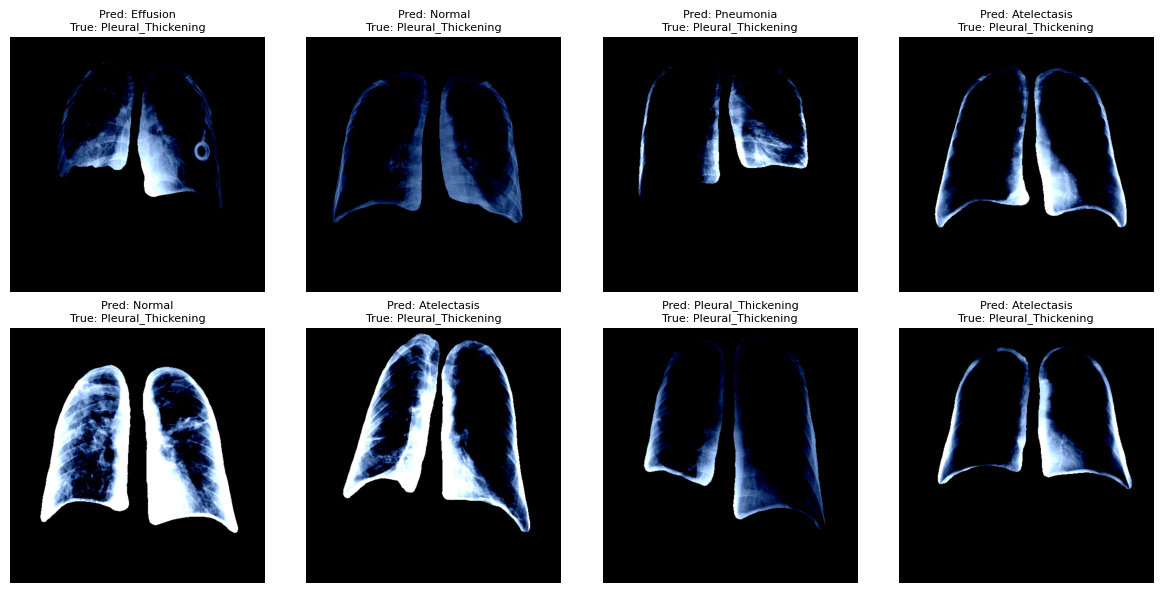

In [32]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

TOP_K = 5   # mude para 2 se quiser só as duas mais prováveis

# ===== pegar melhor modelo do ranking =====
BEST_MODEL = final_rank.iloc[0]["model"]
BEST_PHASE = final_rank.iloc[0]["phase"]
BEST_CKPT  = final_rank.iloc[0]["ckpt"]
BEST_ARCH  = MODEL_REGISTRY[BEST_MODEL]

print(f"Usando modelo: {BEST_MODEL} | fase: {BEST_PHASE} | ckpt: {BEST_CKPT}")

# ===== carregar learner =====
learn = get_learner(data, BEST_ARCH, pretrained=True, unfreeze=False)
learn.load(BEST_CKPT)

# ===== montar DataLoader de teste =====
test_root = PATH_DATASET / "test"
test_files = get_image_files(test_root)
test_dl = data.test_dl(test_files, with_labels=True)

# ===== pegar UM batch =====
xb, yb = first(test_dl)
preds = learn.model(xb.to(learn.dls.device))      # logits
probs = preds.softmax(dim=1)                      # [batch, num_classes]

vocab = list(map(str, (getattr(data, 'vocab', None) or getattr(data.train, 'vocab', []))))

n_show = min(8, xb.shape[0])

# tabela básica (classe prevista vs verdadeira)
rows = []
for i in range(n_show):
    true_idx = int(yb[i])
    pred_idx = int(probs[i].argmax().cpu())
    pred_conf = float(probs[i][pred_idx].cpu())
    rows.append({
        "idx_batch": i,
        "true_label": vocab[true_idx],
        "pred_label": vocab[pred_idx],
        "pred_conf(%)": round(pred_conf*100, 2)
    })
df_preds = pd.DataFrame(rows)
display(df_preds)

# ===== imprimir top-k por imagem =====
for i in range(n_show):
    probs_i = probs[i].cpu()
    top_conf, top_idx = probs_i.topk(min(TOP_K, probs_i.shape[0]))
    print(f"\nImagem {i} — true: {df_preds.loc[i, 'true_label']}")
    for rank, (c, idx_) in enumerate(zip(top_conf, top_idx), start=1):
        print(f"  {rank}. {vocab[int(idx_)]} -> {float(c)*100:.2f}%")

# (opcional) ver imagem + rótulos
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()
for i in range(n_show):
    img = xb[i].cpu().permute(1,2,0)
    axes[i].imshow(img)
    axes[i].set_title(f"Pred: {df_preds.loc[i,'pred_label']}\nTrue: {df_preds.loc[i,'true_label']}", fontsize=8)
    axes[i].axis("off")
plt.tight_layout()
plt.show()


# **24. Grad-CAM do melhor modelo em exemplos corretamente classificados**

Aplica Grad-CAM ao modelo campeão para gerar mapas de ativação em exemplos corretamente classificados do conjunto de teste, selecionando um caso por classe. Os mapas destacam as regiões da imagem que mais contribuíram para a decisão da rede, permitindo avaliar se o modelo está focando em áreas clinicamente relevantes.


Usando melhor modelo: resnet34 (finetune) – ckpt=resnet34_finetune
Classes: ['Atelectasis', 'Fibrosis', 'Normal', 'Pleural_Thickening', 'Pneumonia']
Camada alvo para Grad-CAM: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Classes presentes no /test depois do filtro: ['Atelectasis', 'Fibrosis', 'Normal', 'Pleural_Thickening', 'Pneumonia']


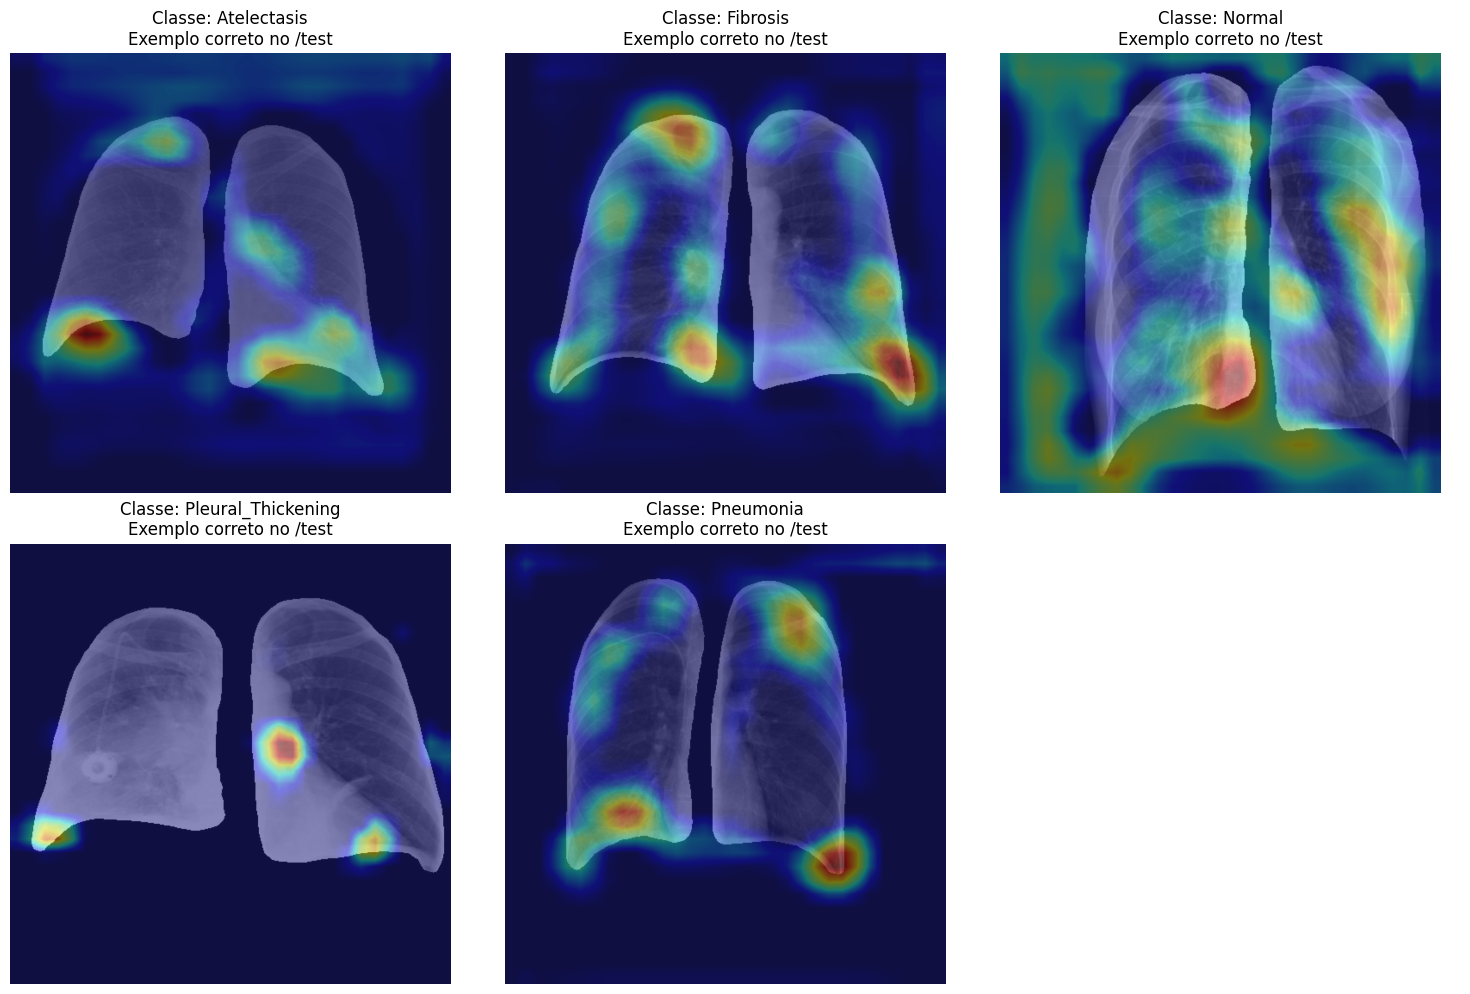

In [21]:
# %%
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision

from fastai.vision.all import PILImage, get_image_files

# ----------------------------
# 1) Recupera melhor modelo
# ----------------------------
BEST_MODEL = final_rank.iloc[0]["model"]
BEST_PHASE = final_rank.iloc[0]["phase"]
BEST_CKPT  = final_rank.iloc[0]["ckpt"]
BEST_ARCH  = MODEL_REGISTRY[BEST_MODEL]

print(f"Usando melhor modelo: {BEST_MODEL} ({BEST_PHASE}) – ckpt={BEST_CKPT}")

learn = get_learner(data, BEST_ARCH, pretrained=True, unfreeze=False)
learn.load(BEST_CKPT)
learn.to_fp32()          # MUITO IMPORTANTE para Grad-CAM
learn.model.eval();

# Vocabulário de classes (já filtrado pelo ALLOWED_LABELS)
vocab = list(map(str, (getattr(data, 'vocab', None) or getattr(data.train, 'vocab', []))))
n_classes = len(vocab)
print("Classes:", vocab)

# ----------------------------
# 2) Função para achar camada-alvo
#    (última convolução do backbone)
# ----------------------------
def get_target_layer(model: nn.Module) -> nn.Module:
    """
    Tenta escolher a última camada convolucional do modelo,
    com casos especiais para ResNet, VGG e EfficientNet.
    """
    # Desembrulha se for um Sequential dentro de um wrapper
    if isinstance(model, nn.Sequential) and len(model) == 1:
        model = model[0]

    # Casos comuns torchvision
    if isinstance(model, torchvision.models.ResNet):
        return model.layer4[-1]
    if isinstance(model, torchvision.models.vgg.VGG):
        # Último bloco conv
        for m in reversed(model.features):
            if isinstance(m, nn.Conv2d):
                return m
    if hasattr(torchvision.models, "EfficientNet") and isinstance(model, torchvision.models.EfficientNet):
        # último bloco de features
        return model.features[-1]

    # Fallback genérico: última Conv2d encontrada
    for m in reversed(list(model.modules())):
        if isinstance(m, nn.Conv2d):
            return m

    raise ValueError("Não foi encontrada nenhuma camada Conv2d para usar no Grad-CAM.")

target_layer = get_target_layer(learn.model)
print("Camada alvo para Grad-CAM:", target_layer)

# ----------------------------
# 3) Função Grad-CAM
# ----------------------------
def compute_gradcam(model: nn.Module, x: torch.Tensor, class_idx: int, target_layer: nn.Module):
    """
    Calcula Grad-CAM para um batch x (B=1) e uma classe target (class_idx).
    Retorna um mapa 2D numpy normalizado em [0,1].
    """
    activations = []
    gradients   = []

    def fwd_hook(module, inp, out):
        activations.append(out.detach())

    def bwd_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].detach())

    # Registra hooks
    h_fwd = target_layer.register_forward_hook(fwd_hook)
    h_bwd = target_layer.register_backward_hook(bwd_hook)

    try:
        model.zero_grad(set_to_none=True)
        logits = model(x)
        # Score da classe-alvo
        score = logits[:, class_idx].sum()
        score.backward()

        # Extrai ativação e gradiente (batch 0)
        acts = activations[0][0]  # [C,H,W]
        grads = gradients[0][0]   # [C,H,W]

        # Pesos: média global dos gradientes
        weights = grads.mean(dim=(1, 2))  # [C]

        # Combinação linear
        cam = torch.zeros_like(acts[0])
        for w, a in zip(weights, acts):
            cam += w * a

        cam = F.relu(cam)

        # Normaliza para [0,1]
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()

        cam_np = cam.cpu().numpy()
    finally:
        h_fwd.remove()
        h_bwd.remove()

    return cam_np

# ----------------------------
# 4) Seleciona um exemplo CORRETO por classe no /test
#    (USANDO TESTE FILTRADO POR ALLOWED_LABELS)
# ----------------------------
test_root = PATH_DATASET / "test"

# Usa o mesmo filtro de classes do experimento
test_files = [
    f for f in get_image_files(test_root)
    if f.parent.name in ALLOWED_LABELS
]

assert len(test_files) > 0, f"Nenhuma imagem em {test_root} após aplicar o filtro de classes!"

# Sanidade: ver quais classes realmente aparecem no test
labels_test_presentes = sorted({f.parent.name for f in test_files})
print("Classes presentes no /test depois do filtro:", labels_test_presentes)

test_dl = data.test_dl(test_files, with_labels=True)
preds, targs = learn.get_preds(dl=test_dl)
y_true = targs.cpu().numpy()
y_pred = preds.argmax(dim=1).cpu().numpy()

items = list(test_dl.items)  # caminhos das imagens

# Índices por classe com predição correta
idxs_por_classe = {}
for cls_idx in range(n_classes):
    idxs = np.where((y_true == cls_idx) & (y_pred == cls_idx))[0]
    if len(idxs) > 0:
        idxs_por_classe[cls_idx] = int(idxs[0])  # pega só o primeiro exemplo
    else:
        print(f"⚠️ Nenhum exemplo corretamente classificado para classe '{vocab[cls_idx]}' no /test.")

# ----------------------------
# 5) Plota Grad-CAM: um subplot por classe
# ----------------------------
n_plots = len(idxs_por_classe)
if n_plots == 0:
    print("Não há exemplos corretamente classificados para nenhuma classe no /test.")
else:
    n_cols = 3
    n_rows = math.ceil(n_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for ax in axes[n_plots:]:
        ax.axis("off")

    for i, (cls_idx, global_idx) in enumerate(idxs_por_classe.items()):
        ax = axes[i]
        img_path = items[global_idx]

        # Cria um mini dataloader só com essa imagem para respeitar os transforms
        one_dl = data.test_dl([img_path], with_labels=False)
        batch = one_dl.one_batch()

        # batch pode ser xb ou (xb,)
        if isinstance(batch, (list, tuple)):
            xb = batch[0]
        else:
            xb = batch

        # 🔴 AQUI ESTAVA O PROBLEMA
        # xb = xb.to(learn.model.device)
        xb = xb.to(learn.dls.device)   # usa o device dos DataLoaders

        # Calcula Grad-CAM
        cam = compute_gradcam(learn.model, xb, class_idx=cls_idx, target_layer=target_layer)

        # Imagem original (redimensionada para o input da rede)
        pil_img = PILImage.create(img_path)
        H, W = xb.shape[-2], xb.shape[-1]
        pil_resized = pil_img.resize((W, H))

        img_np = np.array(pil_resized).astype(np.float32)
        if img_np.ndim == 2:  # grayscale -> 3 canais
            img_np = np.stack([img_np]*3, axis=-1)
        img_np = img_np / 255.0

        # Redimensiona CAM para (H,W)
        cam_resized = F.interpolate(
            torch.tensor(cam)[None, None, ...],
            size=(H, W),
            mode="bilinear",
            align_corners=False
        )[0, 0].cpu().numpy()

        # Plot: imagem + heatmap
        ax.imshow(img_np, alpha=0.9)
        ax.imshow(cam_resized, cmap="jet", alpha=0.4)
        ax.set_title(f"Classe: {vocab[cls_idx]}\nExemplo correto no /test")
        ax.axis("off")

    plt.tight_layout()
    plt.show()



# Treino

In [21]:
#path_dataset = Path("/lapix/compartilhado/asbestos/resnet/resnet_img_filtradas/Padchest_NIH/Padchest_NIH/dataset2/")
#path_img = (
#    path_dataset / "labels"
#)  # Images root folder. The images must be inside the [train|val|test]/[class] folders.
#path_output = Path("output2")
#path_models = (
#    path_output /"models"
#)  # Folder where the models/weights should be saved in
#
#path_models.mkdir(parents=True, exist_ok=True)

In [22]:
# ===== Parâmetros =====
#BASE_PATH      = "\"
#PATH_DATASET   = os.path.join("/lapix/compartilhado/asbestos/resnet/resnet_img_filtradas/Padchest_NIH/Padchest_NIH/dataset2/")
#PATH_LABELS    = os.path.join(PATH_DATASET, "labels")   # onde estão NORMAL/ e PNEUMONIA/ com as imagens
#PATH_TRAIN     = os.path.join(PATH_DATASET, "train")
#PATH_VAL       = os.path.join(PATH_DATASET, "val")
#PATH_TEST      = os.path.join(PATH_DATASET, "test")

In [13]:
from fastai.vision.models import resnet34

used_model = resnet34

In [14]:
import albumentations as A
# Gerar aumentação de dados sintéticos
augmentations = A.Compose([
    A.HorizontalFlip(p=0.0),  # p=0.5 (se você insistir em manter)
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.05, rotate_limit=7, p=0.7),
    A.RandomBrightnessContrast(0.08, 0.08, p=0.6),
    A.RandomGamma(gamma_limit=(90,110), p=0.4),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=0.2),
], p=1.0)

transforms = [AlbumentationsTransform(augmentations)]

In [15]:
# Definir o array das métricas
metrics = [
    accuracy,
    F1Score(average="macro"),
    Precision(average="macro"),
    Recall(average="macro"),
]

In [16]:
PATH_TRAIN, PATH_DATASET, path_dataset

('/lapix/compartilhado/asbestos/resnet/resnet_img_filtradas/Padchest_NIH_reduzido/train',
 '/lapix/compartilhado/asbestos/resnet/resnet_img_filtradas/Padchest_NIH_reduzido',
 Path('/lapix/compartilhado/asbestos/resnet/resnet_img_filtradas/Padchest_NIH_reduzido'))

In [17]:
# Defina o tamanho do seu lote de imagens para processamento pela rede
bs = 16

# Carregue os dados usando função nativa do fast.ai
batch_tfms = [
    AlbumentationsTransform(augmentations),
    Normalize.from_stats(*imagenet_stats),
]

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = ImageDataLoaders.from_folder(path_dataset, train='train', valid='val', test=Path(os.path.join(PATH_DATASET, "test"))
                                    ,bs=bs,item_tfms=Resize(1024),
                                    batch_tfms=batch_tfms, device=dev)
# # Carregue os dados usando função nativa do fast.ai
# data = ImageDataLoaders.from_folder(path_dataset, train='train', valid='val', test=Path(os.path.join(PATH_DATASET, "test"))
#                                     ,bs=bs,item_tfms=transforms,
#                                     batch_tfms=Normalize.from_stats(*imagenet_stats),)

In [18]:
#def get_learner(data, load_model=None, unfreeze:bool=False):
#  """Creates and setups the learner for each step of the training approach.
#
#  Args:
#      data: Dataloader.
#      load_model (str): Path to the model to be loaded.
#      unfreeze (bool): Indicates if the model should be unfreezed. Defaults to False.
#  """
#  learn = vision_learner(data,
#                      used_model,
#                      metrics=metrics,
#                      loss_func=CrossEntropyLossFlat()).to_fp16()
#
#  learn.path = path_models
#  if(load_model != None):
#    learn.load(load_model)
#  if(unfreeze):
#    learn.unfreeze()
#  return learn

import torch
from fastai.vision.all import *

def get_learner(dls, load_model=None, unfreeze: bool = False):
    dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"✅ Usando device: {dev}")

    # assegura que os DataLoaders estão no device certo
    dls = dls.to(dev)

    learn = vision_learner(
        dls,
        used_model,                     # ex.: resnet34
        metrics=metrics,
        loss_func=CrossEntropyLossFlat()
    )

    # move o modelo explicitamente (boa prática)
    learn.to(dev)

    # mixed precision em NVIDIA
    if dev.type == 'cuda':
        learn = learn.to_fp16()

    learn.path = path_models

    if load_model is not None:
        learn.load(load_model)
        print(f"📂 Modelo carregado: {load_model}")

    if unfreeze:
        learn.unfreeze()
        print("🔓 Unfreeze aplicado")

    return learn



In [ ]:
### LEARNER COM CALLBACKS
### (salvamento automático, early stopping, redução de LR)

#def get_learner(
#    dls,
#    load_model: str | None = None,
#    unfreeze: bool = False,
#    monitor: str = "f1_score",    # métrica a monitorar (deve existir no `metrics`)
#    comp: str = "max",            # "max" p/ f1/acc; "min" p/ loss
#    save_fname: str = "best_model",
#    early_stop: bool = True,
#    early_patience: int = 5,
#    reduce_on_plateau: bool = True,
#    reduce_factor: float = 0.2,
#    reduce_patience: int = 2,
#    set_seed_val: int | None = 42,  # para reprodutibilidade; use None se não quiser fixar
#):
#    # Device
#    dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#    print(f"Usando device: {dev}")
#
#    # (Opcional) determinismo
#    if set_seed_val is not None:
#        set_seed(set_seed_val, reproducible=True)
#        # Se quiser máxima performance com tamanhos fixos de input:
#        # torch.backends.cudnn.benchmark = True  # (pode reduzir reprodutibilidade)
#
#    # Learner
#    learn = vision_learner(
#        dls,
#        used_model,                      # sua arch, ex.: resnet34
#        metrics=metrics,                 # ex.: [accuracy, F1Score(average='macro')]
#        loss_func=CrossEntropyLossFlat(),
#        device=dev
#    )
#
#    # GPU mixed precision
#    if dev.type == 'cuda':
#        learn = learn.to_fp16()
#
#    # Callbacks
#    cbs = [
#        SaveModelCallback(
#            monitor=monitor,
#            comp=np.greater if comp == "max" else np.less,
#            fname=save_fname,
#            with_opt=True
#        )
#    ]
#
#    if early_stop:
#        cbs.append(EarlyStoppingCallback(
#            monitor=monitor,
#            comp=np.greater if comp == "max" else np.less,
#            patience=early_patience
#        ))
#
#    if reduce_on_plateau:
#        cbs.append(ReduceLROnPlateau(
#            monitor=monitor,
#            comp=np.greater if comp == "max" else np.less,
#            factor=reduce_factor,
#            patience=reduce_patience
#        ))
#
#    learn.add_cbs(cbs)
#
#    # Carregar pesos, se houver
#    if load_model is not None:
#        learn.load(load_model)
#        print(f"Modelo carregado: {load_model}")
#
#    # Descongelar, se pedido
#    if unfreeze:
#        learn.unfreeze()
#        print("Unfreeze aplicado.")
#
#    return learn


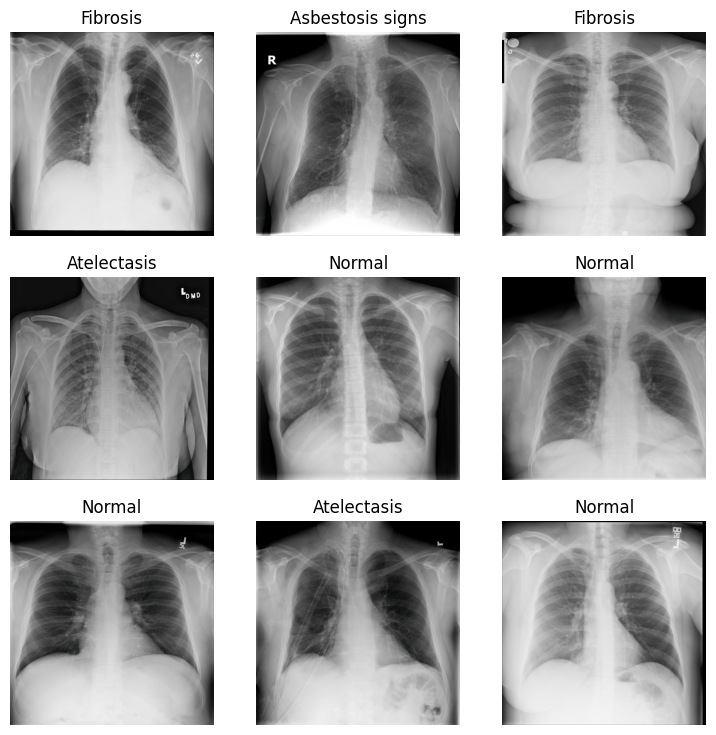

In [19]:
data.show_batch()


✅ Usando device: cuda


SuggestedLRs(valley=0.0014454397605732083)


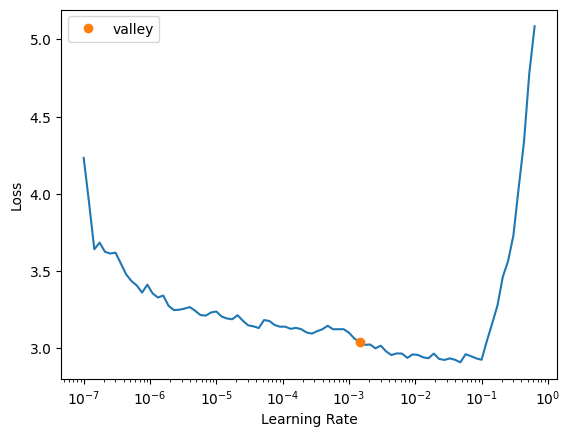

In [20]:
# Runs the learning rate finder
suggested_lr = get_learner(data).lr_find()
print(suggested_lr)

✅ Usando device: cuda


Better model found at epoch 0 with f1_score value: 0.2113112124011037.


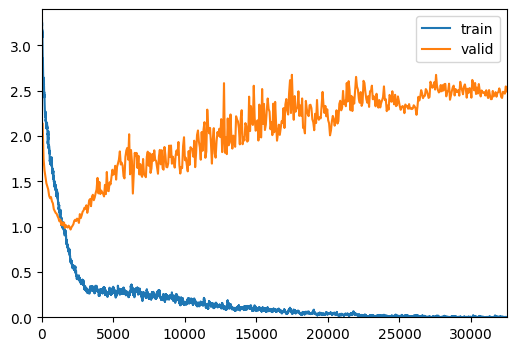

Better model found at epoch 1 with f1_score value: 0.34920846145553447.
Better model found at epoch 2 with f1_score value: 0.3821291779497699.
Better model found at epoch 4 with f1_score value: 0.4384793403299111.
Better model found at epoch 5 with f1_score value: 0.4406650053695876.
Better model found at epoch 6 with f1_score value: 0.46157664986632635.
Better model found at epoch 7 with f1_score value: 0.46520296163190206.
Better model found at epoch 8 with f1_score value: 0.4859711141190147.
Better model found at epoch 10 with f1_score value: 0.521660482374768.
Better model found at epoch 12 with f1_score value: 0.5296460699836797.
Better model found at epoch 13 with f1_score value: 0.5702540845397989.
Better model found at epoch 16 with f1_score value: 0.5867877646262032.
Better model found at epoch 17 with f1_score value: 0.6043176885221218.
Better model found at epoch 20 with f1_score value: 0.6133119411830338.
Better model found at epoch 21 with f1_score value: 0.616581279496222

In [21]:
lr = suggested_lr.valley  # Incluir aqui a taxa de aprendizado encontrada no passo anterior
wd = 1e-3  # decaimento da rede
TRAIN_EPOCH = 500
learn = get_learner(data)
callbacks = [
    SaveModelCallback(
        monitor="f1_score", fname="best_model_resnet_34_stg1", with_opt=True
    ),  # Saves the best model as `fname` in `learn.path` considering the metric defined in `monitor`.
    ShowGraphCallback(),  # Shows the train/validation graph
]

# Train
learn.fit_one_cycle(TRAIN_EPOCH,lr_max=lr, wd=wd, cbs=callbacks)

✅ Usando device: cuda
📂 Modelo carregado: best_model_resnet_34_stg1


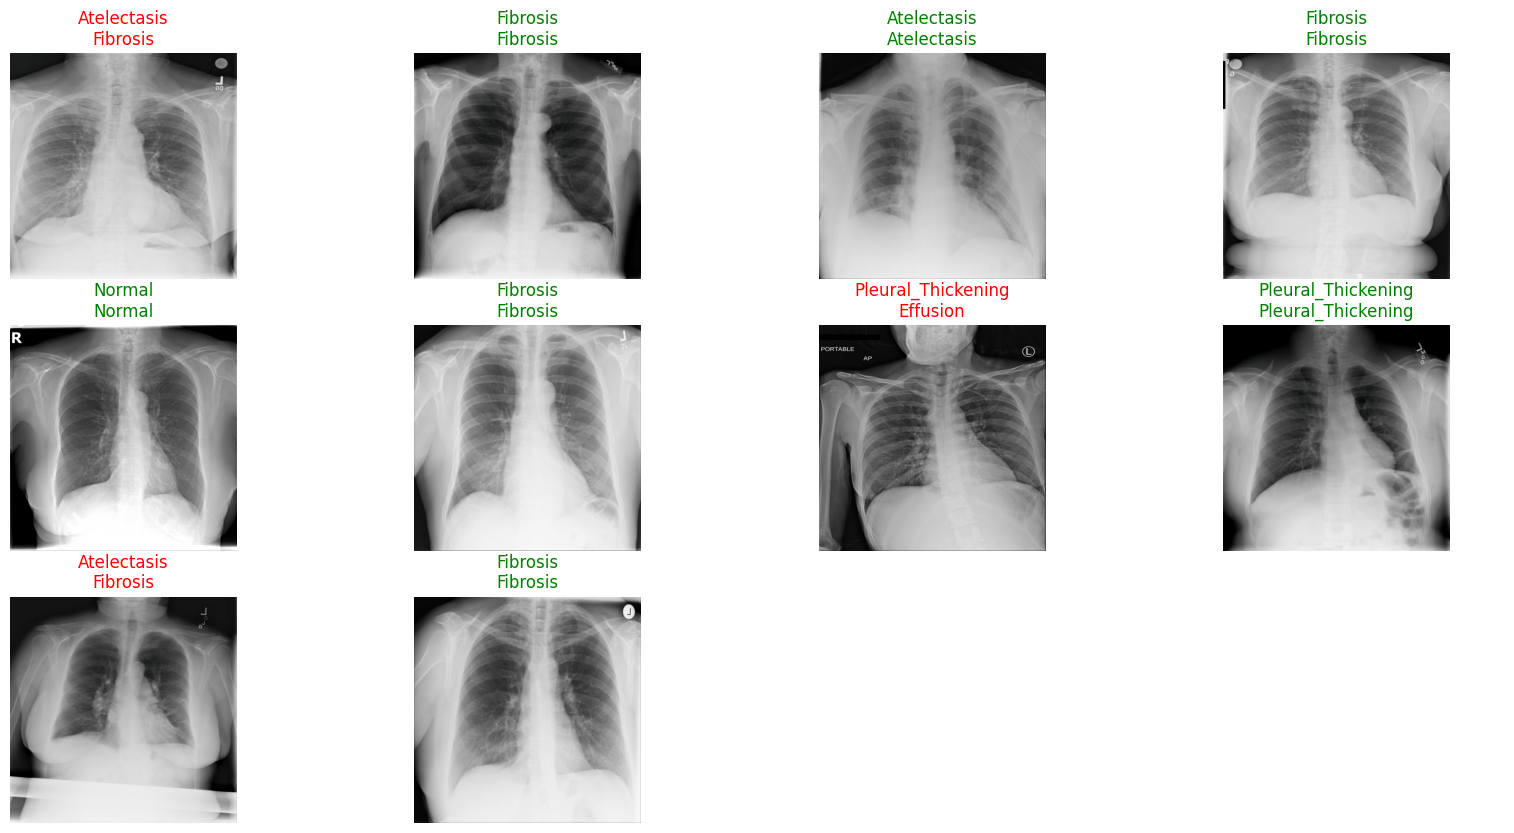

In [22]:
get_learner(data, "best_model_resnet_34_stg1").show_results(
    max_n=10, figsize=(20, 10)
)  # Mostra exemplos de resultado do modelo definido

# Resultado

✅ Usando device: cuda
📂 Modelo carregado: best_model_resnet_34_stg1


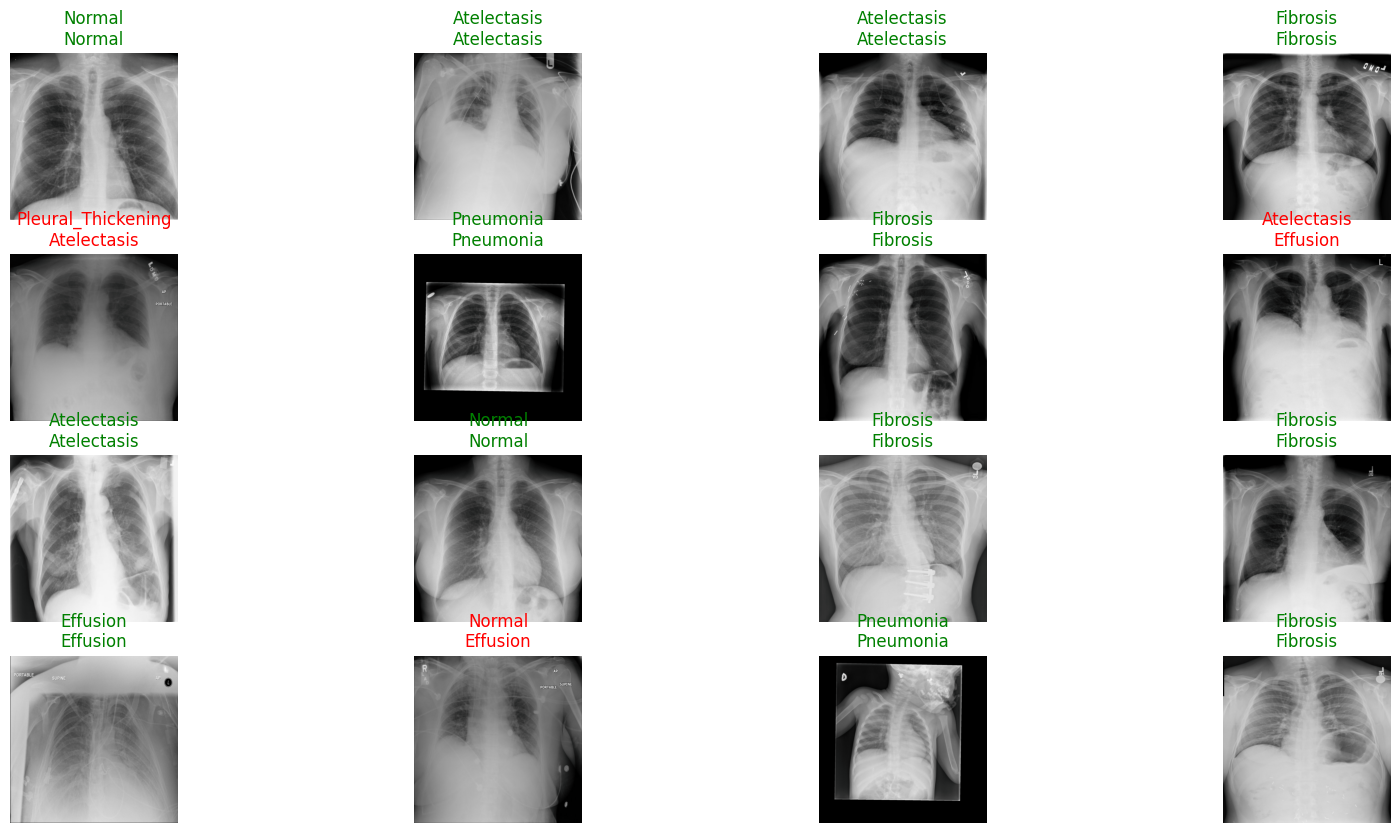

In [23]:
#get_learner(data, "best_model_stg2").show_results(max_n=16, figsize=(20, 10))
get_learner(data, "best_model_resnet_34_stg1").show_results(max_n=16, figsize=(20, 10))

In [1]:
bs = 1
path_test = path_dataset / "test"
data_test = ImageDataLoaders.from_folder(path = path_dataset,train='test',valid='test',test = path_test, bs=bs,
                                    batch_tfms=Normalize.from_stats(*imagenet_stats),)

NameError: name 'path_dataset' is not defined

In [24]:
learn = get_learner(data_test, "best_model_resnet_34_stg1") # utilizamos como teste o último peso do modelo treinado
ds_test = data_test.valid_ds

NameError: name 'data_test' is not defined

In [ ]:
# === Avaliação sem LapixDL (fastai + scikit-learn) ===
from fastai.vision.all import *
import numpy as np
import torch
from pathlib import Path
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, roc_auc_score
)
import matplotlib.pyplot as plt

# Ajuste se sua variável dos dataloaders tiver outro nome
dls = data if 'data' in globals() else learn.dls
vocab = list(map(str, (getattr(dls, 'vocab', None) or getattr(dls.train, 'vocab', []))))

# (1) Garanta um DataLoader de teste COM RÓTULOS a partir de /test
test_root = Path(PATH_DATASET) / "test"
assert test_root.exists(), f"Pasta de teste não encontrada: {test_root}"

# get_image_files pega todos os arquivos; with_labels=True usa as pastas/nomes como rótulos
test_files = get_image_files(test_root)
assert len(test_files) > 0, f"Nenhuma imagem encontrada em {test_root}"

test_dl = dls.test_dl(test_files, with_labels=True)

# (2) Predições e alvos
preds, targs = learn.get_preds(dl=test_dl)   # preds: [N, C], targs: [N]
pred_idxs = preds.argmax(dim=1)

# (3) Métricas gerais
y_true = targs.cpu().numpy()
y_pred = pred_idxs.cpu().numpy()
acc = accuracy_score(y_true, y_pred)

print(f"Accuracy (test): {acc:.4f}\n")

# Relatório por classe
if not vocab:  # fallback de nomes de classe
    n_classes = preds.shape[1]
    vocab = [f"class_{i}" for i in range(n_classes)]
print(classification_report(y_true, y_pred, target_names=[str(x) for x in vocab]))

# (4) Matriz de confusão (plot)
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, interpolation='nearest')
ax.set_title("Confusion Matrix (test)")
ax.set_xticks(range(len(vocab))); ax.set_xticklabels(vocab, rotation=45, ha='right')
ax.set_yticks(range(len(vocab))); ax.set_yticklabels(vocab)
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center')
plt.xlabel("Predicted"); plt.ylabel("True")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# (5) ROC-AUC (opcional): só faz sentido para binário ou em esquema one-vs-rest
try:
    if preds.shape[1] == 2:
        # prob da classe positiva (assumindo índice 1)
        y_score = preds[:, 1].cpu().numpy()
        roc_auc = roc_auc_score(y_true, y_score)
        print(f"ROC-AUC (binário): {roc_auc:.4f}")
    else:
        # Macro AUC one-vs-rest
        y_true_ovr = np.eye(preds.shape[1])[y_true]
        y_score = preds.cpu().numpy()
        roc_auc_macro = roc_auc_score(y_true_ovr, y_score, average='macro', multi_class='ovr')
        print(f"ROC-AUC macro (multiclasse, OvR): {roc_auc_macro:.4f}")
except Exception as e:
    print(f"[Aviso] ROC-AUC não pôde ser calculado: {e}")

# (6) Helpers equivalentes aos seus
def top5(img):
    pred_class, pred_idxs, outputs = learn.predict(img)
    top_5_conf, top_5_idx = outputs.topk(min(5, len(outputs)))
    for rank, i in enumerate(top_5_idx):
        print(f"Class: {vocab[int(i)]}, Probability: {top_5_conf[rank].item()*100:.4f} %")
    print()

def get_prediction(img, correct_label_name):
    pred_class, pred_idx, outputs = learn.predict(img)
    idx = vocab.index(str(correct_label_name))
    print(f"{outputs[idx].item()*100:.10f} %\n")
